<div align="center"><h1><b>Step 2: Query and PreProcess Legitimate User Tweets</b></h1></div>

**Outline**

1. Take the list of words generated from the BoW in Step 1, and create a random list of words from it
2. Perform topical queries on Twitter API using random list of words to generate random sample of users with similar discussion topics to Russian tweets
3. Take unique users from random sample and query tweets from their user timelines
4. Preprocess legitimate user tweets to create BoW feature
5. Assign users scores using the Botometer API to ensure bots are not in the legitimate user sample
6. Ensure consistency between the user and tweet datasets and address anomalies from query
7. Save final list of legitimate users and tweets

In [ ]:
# Import necessary libraries

# For accessing Google Drive Files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Connect and authenticate Google Drive with Google CoLab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount('/drive')
drive = GoogleDrive(gauth)

# For preprocessing, Twitter API access
import CS3315Project.tweetProcessing as tweetProcessing
import CS3315Project.tweetMiner as tweetMiner
import pandas as pd
import re
import itertools
import numpy as np 
import random
!pip install botometer
import botometer
import tweepy

Mounted at /drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


We cannot directly access random users via the Twitter API in an efficient way, so instead we will generate random english words to query and pull random users from the results. We are using the words generated from preprocessing the Russian disinformation tweets, so that similar topics are represented in the dataset, which will help differentiate authentic versus inauthentic activity given tweets about a particular topic. This is preferable to generating random words from a different dictionary, as it may create artificial clustering between the legitimate/Russian datasets.

In [ ]:
# Access BoW list csv generated in step one to use as source of search terms

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('BoW_list.csv')

BoW_list = pd.read_csv('BoW_list.csv')

BoW_list = BoW_list.drop('Unnamed: 0', axis=1)

BoW_list.head()

,0
0,schumer
1,fight
2,hard
3,healthcare
4,breaking


In [ ]:
# See number of words in list

print('BoW_list contains ' + str(len(BoW_list['0'].unique())) + ' unique words.')

BoW_list = BoW_list['0'].to_list()

print('BoW_list contains ' + str(len(BoW_list)) + ' total words.')

BoW_list contains 563377 unique words.
BoW_list contains 25741529 total words.


From our previous analysis, we know that we need to query for approximately 4,000 users. Since we cannot match the number of tweets per user in the Russian dataset, we will just grab as many as we can.

The Twitter rate limit is 180 requests every 15 minutes for the topical tweet searches and 900 requests every 15 minutes on user timelines, and 500,000 tweets per month. We need approximately 4100 users worth of tweets (there are 4167 in the Russian dataset), which means that we can collect approximately 120 tweets per user without reaching the Twitter API's monthly rate limit. We will collect 10 users per word search, which means that we will need 410 words for 4100 tweets. Assuming we will need to discard a significant portion of users, we will generate 800 words, collecting 8000 tweets to filter further. We will generate the words from the total BoW list without replacement, as opposed to just the unique word values within the BoW list so that the probability of certain words ocurring factors into
the legitimate tweet dataset in a manner similar to the disinformation dataset.

In [ ]:
# Randomly generate list of words for topical Twitter searches

randwordlist=[]

# Generate 800 random, unique numbers as indices to grab random words
randindexlist = random.sample(range(0, len(BoW_list)), 800)

# Create list of random words
for i in randindexlist:
    randwordlist.append(BoW_list[i])

len(randwordlist)

800

In [ ]:
# Instantiate tweetMiner Object
# Grab 10 tweets per query of 800 words, for 8000 total tweets, assume some users will need to be discarded due to language or duplicates to get at least 4100

userminer = tweetMiner.TweetMiner(result_limit=10)

In [ ]:
# Iterate through random list of words, grab 10 tweets per word search

mined_topical_tweets_df = pd.DataFrame()

for word in randwordlist:
  mined_topical_tweets, mined_topical_rawtweets = userminer.mine_topical_tweets(max_pages = 1, topic = word)
  mined_topical_tweets = pd.DataFrame(mined_topical_tweets)
  mined_topical_tweets_df = pd.concat([mined_topical_tweets_df, mined_topical_tweets], ignore_index=True)

Mining  infowars
    Mining 1 of 1 total pages
Mining  admit
    Mining 1 of 1 total pages
Mining  gonna
    Mining 1 of 1 total pages
Mining  day
    Mining 1 of 1 total pages
Mining  asshole
    Mining 1 of 1 total pages
Mining  crookedhillary
    Mining 1 of 1 total pages
Mining  resident
    Mining 1 of 1 total pages
Mining  shield
    Mining 1 of 1 total pages
Mining  price
    Mining 1 of 1 total pages
Mining  europe
    Mining 1 of 1 total pages
Mining  white
    Mining 1 of 1 total pages
Mining  amp
    Mining 1 of 1 total pages
Mining  happily
    Mining 1 of 1 total pages
Mining  nypd
    Mining 1 of 1 total pages
Mining  hijab
    Mining 1 of 1 total pages
Mining  college
    Mining 1 of 1 total pages
Mining  arthur
    Mining 1 of 1 total pages
Mining  pope
    Mining 1 of 1 total pages
Mining  subway
    Mining 1 of 1 total pages
Mining  dirtyrice
    Mining 1 of 1 total pages
Mining  news
    Mining 1 of 1 total pages
Mining  art
    Mining 1 of 1 total pages
Mining  rece

In [ ]:
# See number of tweets mined, some searched topics may not have yielded results

print(mined_topical_tweets_df.shape)
mined_topical_tweets_df.head()

(7225, 30)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1326752296240287744,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2654,2026,2009-10-12 19:58:13,None,en,"RT @space_is_fizzy: So Infowars has a ""caravan...",2020-11-12 05:02:51,Twitter for iPhone,NaN,NaN,None,True,66611043,1326748302235332608,absent,absent,4,None,0,4,[],[],"[{'screen_name': 'space_is_fizzy', 'name': '𝕰𝖓..."
1,1326752293014761473,1209338232946614272,GreenbookStarWars,GainesISBN,Palm Springs,"Investigator who understands the Law (4,5,6,8,...",None,0,84,2019-12-24 05:02:59,None,en,@VRallstars69 @SW_takes More like infowars,2020-11-12 05:02:51,Twitter Web App,4.92051e+09,1.32627e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'VRallstars69', 'name': 'feru..."
2,1326750614135726081,1284532198440415232,School Pride Bands,bands_pride,"Cincinnati, OH",We sell affordable stylish custom bands for yo...,https://t.co/WApxyVl0RS,24,606,2020-07-18 16:55:24,None,en,@KELLEIGH888 The beef was probably with Owen S...,2020-11-12 04:56:10,Twitter for iPhone,9.69719e+17,1.32674e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'KELLEIGH888', 'name': 'Kelle..."
3,1326750572540784643,3118442799,TeaPartyOfSuffolk ❌,TPP_of_Suffolk,"Suffolk County, Long Islandq","RN, Patriot 30 YRS @war/w left. Our Lives, Our...",http://t.co/mo29e3btXI,7881,7936,2015-03-26 13:02:16,None,en,https://t.co/AQdVIC6FM6\n\nThis letter is AN E...,2020-11-12 04:56:00,Twitter Web App,NaN,NaN,None,False,None,None,absent,absent,0,None,0,0,[],"[{'url': 'https://t.co/AQdVIC6FM6', 'expanded_...",[]
4,1326752362166444032,1265162708061761536,♥︎ tangy ♥︎,orangycat,Kerberos ☆,🍊 check my profile for my bio 🍊 (WIP) 🍊 🍊 impe...,https://t.co/S9Uo49Yl7T,411,278,2020-05-26 06:08:14,None,en,@Stinky_ACNH @MarshalSmug @_ACNH_Raymond_ Gott...,2020-11-12 05:03:07,Twitter Web App,1.26851e+18,1.32662e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'Stinky_ACNH', 'name': 'Stink..."


In [ ]:
# Filter collected tweets for unique users

mined_topical_tweets_df = mined_topical_tweets_df.drop_duplicates(subset=['userid'])

print(mined_topical_tweets_df.shape)
mined_topical_tweets_df.head()

(6809, 30)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1326752296240287744,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2654,2026,2009-10-12 19:58:13,None,en,"RT @space_is_fizzy: So Infowars has a ""caravan...",2020-11-12 05:02:51,Twitter for iPhone,NaN,NaN,None,True,66611043,1326748302235332608,absent,absent,4,None,0,4,[],[],"[{'screen_name': 'space_is_fizzy', 'name': '𝕰𝖓..."
1,1326752293014761473,1209338232946614272,GreenbookStarWars,GainesISBN,Palm Springs,"Investigator who understands the Law (4,5,6,8,...",None,0,84,2019-12-24 05:02:59,None,en,@VRallstars69 @SW_takes More like infowars,2020-11-12 05:02:51,Twitter Web App,4.92051e+09,1.32627e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'VRallstars69', 'name': 'feru..."
2,1326750614135726081,1284532198440415232,School Pride Bands,bands_pride,"Cincinnati, OH",We sell affordable stylish custom bands for yo...,https://t.co/WApxyVl0RS,24,606,2020-07-18 16:55:24,None,en,@KELLEIGH888 The beef was probably with Owen S...,2020-11-12 04:56:10,Twitter for iPhone,9.69719e+17,1.32674e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'KELLEIGH888', 'name': 'Kelle..."
3,1326750572540784643,3118442799,TeaPartyOfSuffolk ❌,TPP_of_Suffolk,"Suffolk County, Long Islandq","RN, Patriot 30 YRS @war/w left. Our Lives, Our...",http://t.co/mo29e3btXI,7881,7936,2015-03-26 13:02:16,None,en,https://t.co/AQdVIC6FM6\n\nThis letter is AN E...,2020-11-12 04:56:00,Twitter Web App,NaN,NaN,None,False,None,None,absent,absent,0,None,0,0,[],"[{'url': 'https://t.co/AQdVIC6FM6', 'expanded_...",[]
4,1326752362166444032,1265162708061761536,♥︎ tangy ♥︎,orangycat,Kerberos ☆,🍊 check my profile for my bio 🍊 (WIP) 🍊 🍊 impe...,https://t.co/S9Uo49Yl7T,411,278,2020-05-26 06:08:14,None,en,@Stinky_ACNH @MarshalSmug @_ACNH_Raymond_ Gott...,2020-11-12 05:03:07,Twitter Web App,1.26851e+18,1.32662e+18,None,False,None,None,absent,absent,0,None,0,0,[],[],"[{'screen_name': 'Stinky_ACNH', 'name': 'Stink..."


In [ ]:
# Ensure all tweets are English

mined_topical_tweets_df.groupby('tweet_language').size()

tweet_language
ar       13
ca       13
cs        1
da        3
de       33
el        2
en     5550
es      182
et       12
fa        4
fi        6
fr       59
hi       24
ht        6
in      137
it       13
ja      232
ko       70
lv        1
mr        1
nl       10
pl        2
ps        1
pt       87
ro        1
ru        8
sl        1
ta        3
th       73
tl      114
tr       24
uk        1
und     110
ur        1
vi        2
zh        9
dtype: int64

In [ ]:
# Remove non-English tweets, verify they are removed

mined_topical_tweets_df = mined_topical_tweets_df[mined_topical_tweets_df['tweet_language'] == 'en']

mined_topical_tweets_df.groupby('tweet_language').size()

tweet_language
en    5550
dtype: int64

In [ ]:
# Create user info dataframe

user_info_df = mined_topical_tweets_df[['userid', 'user_display_name', 'user_screen_name', 'user_reported_location', 'user_profile_description', 'user_profile_url', 'follower_count', 'following_count', 'account_creation_date', 'account_language']]

print(user_info_df.shape)
user_info_df.head()

(5550, 10)


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
0,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2654,2026,2009-10-12 19:58:13,None
1,1209338232946614272,GreenbookStarWars,GainesISBN,Palm Springs,"Investigator who understands the Law (4,5,6,8,...",None,0,84,2019-12-24 05:02:59,None
2,1284532198440415232,School Pride Bands,bands_pride,"Cincinnati, OH",We sell affordable stylish custom bands for yo...,https://t.co/WApxyVl0RS,24,606,2020-07-18 16:55:24,None
3,3118442799,TeaPartyOfSuffolk ❌,TPP_of_Suffolk,"Suffolk County, Long Islandq","RN, Patriot 30 YRS @war/w left. Our Lives, Our...",http://t.co/mo29e3btXI,7881,7936,2015-03-26 13:02:16,None
4,1265162708061761536,♥︎ tangy ♥︎,orangycat,Kerberos ☆,🍊 check my profile for my bio 🍊 (WIP) 🍊 🍊 impe...,https://t.co/S9Uo49Yl7T,411,278,2020-05-26 06:08:14,None


Now we will filter these users and discard ones that are most likely bots. In order to have a higher degree of certainty in the integrity of our sample, we will assign them a score using the Botometer API. From the resulting score distribution, we can determine a reasonable threshold by which to assume users are legitimate and discard the rest.

In [ ]:
# Further filter users to ensure they are legitimate using the Botometer API

rapidapi_key = "0ae669d71cmsh21253ca9f0c84f5p17b510jsn212cb0b7afa9"
twitter_app_auth = {
    'consumer_key': 'insert-Botometer-key',
    'consumer_secret': 'insert-Botometer-secret',
    'access_token': 'insert-Botometer-token',
    'access_token_secret': 'insert-Botometer-token-secret',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)


# Check a sequence of accounts
accounts = user_info_df['user_screen_name'].to_list()
accounts = ['@' + y for y in accounts]    

len(accounts)

5550

In [ ]:
# Obtain bot scores for every account

user_score_df = pd.DataFrame()
namenotfound = []

for screen_name, result in bom.check_accounts_in(accounts):
  print('Generating score for ' + str(accounts.index(screen_name)) + ' of ' +str(len(accounts)) + ' accounts')
  try:
    name = re.sub('^@', '', screen_name)
    data = {'user_screen_name': [name], 'cap_en': [result['cap']['english']], 'cap_universal': [result['cap']['universal']],'rawscore_en': [result['raw_scores']['english']['overall']], 'rawscore_universal': [result['raw_scores']['universal']['overall']], 'majority_lang': [result['user']['majority_lang']]}
    new_user_score_info = pd.DataFrame.from_dict(data)
    user_score_df = pd.concat([user_score_df, new_user_score_info], ignore_index=True)
  except tweepy.TweepError:
    name = re.sub('^@', '', screen_name)
    namenotfound.append(name)
    continue
  except KeyError:
    name = re.sub('^@', '', screen_name)
    namenotfound.append(name)
    continue

print(user_score_df.shape)
user_score_df.head()

Streaming output truncated to the last 5000 lines.
Generating score for 551 of 5550 accounts
Generating score for 552 of 5550 accounts
Generating score for 553 of 5550 accounts
Generating score for 554 of 5550 accounts
Generating score for 555 of 5550 accounts
Generating score for 556 of 5550 accounts
Generating score for 557 of 5550 accounts
Generating score for 558 of 5550 accounts
Generating score for 559 of 5550 accounts
Generating score for 560 of 5550 accounts
Generating score for 561 of 5550 accounts
Generating score for 562 of 5550 accounts
Generating score for 563 of 5550 accounts
Generating score for 564 of 5550 accounts
Generating score for 565 of 5550 accounts
Generating score for 566 of 5550 accounts
Generating score for 567 of 5550 accounts
Generating score for 568 of 5550 accounts
Generating score for 569 of 5550 accounts
Generating score for 570 of 5550 accounts
Generating score for 571 of 5550 accounts
Generating score for 572 of 5550 accounts
Generating score for 573 

,user_screen_name,cap_en,cap_universal,rawscore_en,rawscore_universal,majority_lang
0,TheLibertyLamp,0.528866,0.288464,0.12,0.03,en
1,GainesISBN,0.391216,0.436508,0.07,0.08,en
2,bands_pride,0.792032,0.800688,0.37,0.37,en
3,TPP_of_Suffolk,0.810078,0.813043,0.79,0.77,en
4,orangycat,0.797167,0.805431,0.52,0.53,en


In [ ]:
# Identify the number of accounts a score could not be determined for

len(namenotfound)

95

In [ ]:
# Save score and names not found data to csv for documenting

namenotfound = pd.Series(namenotfound)

namenotfound.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Bot_Info_Step2/namesnotfound.csv', index=False)
user_score_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Bot_Info_Step2/user_score_df.csv', index=False)

In [ ]:
# Read in csvs 
namenotfoundfile = drive.CreateFile({'id':'insert file id'})
namenotfoundfile.GetContentFile('namesnotfound.csv')

userscorefile = drive.CreateFile({'id':'insert file id'})
userscorefile.GetContentFile('user_score_df.csv')

namenotfound = pd.read_csv('namesnotfound.csv')
user_score_df = pd.read_csv('user_score_df.csv')

The Botometer "cap" score is the probability that another account with similar or greater scoring than the scored account will be a bot. When determining a threshold, Botometer recommends using the cap score to determine a threshold. We will use the cap_universal score to evaluate the accounts with non-English majority language tweets, and we will use the cap_en score to evaluate the accounts with majority-English language tweets. In our case, we need a test set of at least 4100 users, and we currently have tweets from 5455 (after subtracting the namesnotfound variable from our original number of accounts) accounts. For the both users, it seems that the peak of the cap distribution is between 70-80%. After analyzing setting the threshold at different levels, it seems that 80% is a reasonable threshold that leaves us with the sample size we need while discarding accounts with the highest likelihood of being bots in order to limit both false negatives and positives to the best extent possible.

https://botometer.osome.iu.edu/faq#which-score

(5015, 6)


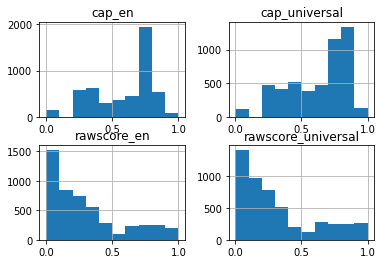

In [ ]:
# Split the dataset into those whose majority language is English and those whose isn't
# See distribution of scores among each set

user_score_en = user_score_df[user_score_df['majority_lang'] == 'en']
user_score_un = user_score_df[user_score_df['majority_lang'] != 'en']

print(user_score_en.shape)
user_score_en_plot = user_score_en.hist()

(440, 6)


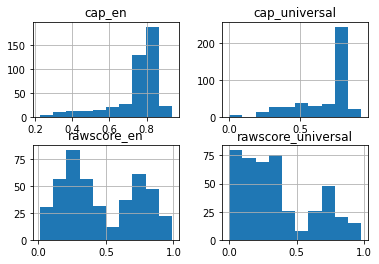

In [ ]:
# See distribution of universal language scores

print(user_score_un.shape)
user_score_un_plot = user_score_un.hist()

In [ ]:
# Count number of users with scores above 80%

user_score_en_bots = user_score_en[user_score_en['cap_en'] > .8]
user_score_un_bots = user_score_un[user_score_un['cap_universal'] > .8]

print(user_score_en_bots.shape)
user_score_un_bots.shape

(621, 6)


(168, 6)

With an 80% threshold, we will need to discard 789 likely bot accounts as well as 95 names that were not found, meaning 884 accounts total. This will leave us with 4,666 from the original 5,550, which is still enough compared to the Russian set of 4167 accounts. We will delete the users from both namesnotfound and those above the threshold from the user info dataframe then save them to csv

In [ ]:
# Create complete list of users to delete

score_en_series = user_score_en_bots['user_screen_name']
score_un_series = user_score_un_bots['user_screen_name']
name_not_found = namenotfound['0']

delete_users = score_en_series, score_un_series, name_not_found

delete_user_df = pd.concat(delete_users, ignore_index=True)

print(delete_user_df.shape)
print(delete_user_df.head())
delete_user_df.tail()

(884,)
0     TPP_of_Suffolk
1    adorablepjminie
2     DragonAdorable
3      RichardLawtld
4        DasiParvesh
dtype: object


879      maidboysapnap
880             _APT_R
881           lijakaca
882    Sayaitumanusia1
883        slipperslol
dtype: object

In [ ]:
# Delete bots from user datasets

user_info_df = user_info_df[~user_info_df.user_screen_name.isin(delete_user_df)]

# Verify equal number of users and size of user dataframe

user_info_df.shape, user_info_df['userid'].unique().shape

((4666, 11), (4666,))

In [ ]:
# Split user info into 10 dataframes

user_info_df1, user_info_df2, user_info_df3, user_info_df4, user_info_df5, user_info_df6, user_info_df7, user_info_df8, user_info_df9, user_info_df10 = np.array_split(user_info_df, 10)

In [ ]:
# Verify number of users is correct

print(user_info_df1.shape)
print(user_info_df2.shape) 
print(user_info_df3.shape) 
print(user_info_df4.shape) 
print(user_info_df5.shape) 
print(user_info_df6.shape) 
print(user_info_df7.shape) 
print(user_info_df8.shape) 
print(user_info_df9.shape) 
print(user_info_df10.shape)

(467, 11)
(467, 11)
(467, 11)
(467, 11)
(467, 11)
(467, 11)
(466, 11)
(466, 11)
(466, 11)
(466, 11)


In [ ]:
# Save user info to csv's for queries

user_info_df1.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_1.csv')
user_info_df2.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_2.csv')
user_info_df3.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_3.csv')
user_info_df4.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_4.csv')
user_info_df5.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_5.csv')
user_info_df6.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_6.csv')
user_info_df7.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_7.csv')
user_info_df8.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_8.csv')
user_info_df9.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_9.csv')
user_info_df10.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/Users_nobots_Step2/leg_usergroup_10.csv')

To get around 12,000,000 tweets to match the Russian dataset for approximately 4200 users, we need approximately 3,000 tweets per user. Each user's query will be for 15 pages from their user timeline and 200 tweets per page, which will result in 3000 tweets per user.

Twitter's API rate limit is 900 requests every 15 minutes. At 15 requests per user, we can pull for 60 users every 15 minutes. This means that pulling for all 4666 users will take just under 20 hours.

https://developer.twitter.com/en/docs/twitter-api/v1/rate-limits

https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/overview

In [ ]:
# Instantiate new tweetMiner Object
# Grab up to 3000 tweets per user total with 15 queries of 200 tweets each

tweetminer = tweetMiner.TweetMiner(result_limit=200)

In [ ]:
# Grab user group 1

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_1.csv')

user_group1_df = pd.read_csv('leg_usergroup_1.csv')

user_group1_df.shape

(467, 12)

In [ ]:
# Query 1
# Take all users from random word searches and query tweets

randuserlist = user_group1_df['user_screen_name'].to_list()

leg_tweetgroup_1_df = pd.DataFrame()
user_rawtweets1 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_1_df, one_user_tweets]
    leg_tweetgroup_1_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_1_df.shape)
leg_tweetgroup_1_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  Coyoteface
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  egreenspon
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
 

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334343130880073729,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2681,2039,2009-10-12 19:58:13,None,en,@expectlettuce Rose scented soap ? 🤷‍♀️,2020-12-03 03:46:07,Twitter for iPhone,1.00494e+18,1.33432e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'expectlettuce', 'name': 'Psy..."
1,1334342111454515202,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2681,2039,2009-10-12 19:58:13,None,en,@TimmyBofficial @MatthewTyrmand @AntifascistF1...,2020-12-03 03:42:04,Twitter for iPhone,2.32962e+09,1.33417e+18,None,True,None,None,None,None,0,None,1,0,[],[],"[{'screen_name': 'TimmyBofficial', 'name': 'Ti..."
2,1334327421684867074,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2681,2039,2009-10-12 19:58:13,None,en,RT @NBC29: A Staunton woman is facing three ye...,2020-12-03 02:43:42,Twitter for iPad,NaN,NaN,None,True,15009049,1334326489211396101,None,None,1,None,0,1,[],[],"[{'screen_name': 'NBC29', 'name': 'NBC29', 'id..."
3,1334327074627203072,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2681,2039,2009-10-12 19:58:13,None,en,RT @PrisonReformMvt: Cops don’t prevent crime.,2020-12-03 02:42:19,Twitter for iPad,NaN,NaN,None,True,27225271,1334322849432166401,None,None,7,None,0,7,[],[],"[{'screen_name': 'PrisonReformMvt', 'name': 'P..."
4,1334326968305717250,81914168,Seitan Worshipper Staying Home 🦠🦠,TheLibertyLamp,In Your Head,Cranky Antifa Yenta. #Bernie2020 She/Her Seita...,https://t.co/Q9qN3W5UWc,2681,2039,2009-10-12 19:58:13,None,und,@Percussioner211 💯,2020-12-03 02:41:54,Twitter for iPad,2.7382e+09,1.33432e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'Percussioner211', 'name': 'M..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_1_df, user_group1_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_1_df['BoW'].head())
print(user_group1_df['BoW'].head())

0                                  [rose, scent, soap]
1       [antifascistf, lukeobrien, luke, sock, puppet]
2    [staunton, woman, face, year, probation, accus...
3                               [cops, prevent, crime]
4                                                   []
Name: BoW, dtype: object
0    [rose, scent, soap, antifascistf, lukeobrien, ...
1    [look, like, wrong, curtain, leave, gun, canno...
2                                                   []
3                                                   []
4    [championforaca, mcdoozie, sirelkmn, victoriaf...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_1_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_1_BoW.csv', index=False)
user_group1_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_1_BoW.csv', index=False)

In [ ]:
# Grab user group 2

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_2.csv')

user_group2_df = pd.read_csv('leg_usergroup_2.csv')

user_group2_df.shape

(467, 12)

In [ ]:
# Query 2
# Take all users from random word searches and query tweets

randuserlist = user_group2_df['user_screen_name'].to_list()

leg_tweetgroup_2_df = pd.DataFrame()
user_rawtweets2 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_2_df, one_user_tweets]
    leg_tweetgroup_2_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_2_df.shape)
leg_tweetgroup_2_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  RB_Phan
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  justanna____
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
  

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1333603820061003777,1551936841,grace bruce,gcbruce02,"New Orleans, LA",NSU,None,1364,694,2013-06-28 01:27:49,None,en,"I needa call a time out, needa call another play",2020-12-01 02:48:22,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,0,None,1,0,[],[],[]
1,1333597891357790213,1551936841,grace bruce,gcbruce02,"New Orleans, LA",NSU,None,1364,694,2013-06-28 01:27:49,None,en,RT @999FamiIy: DROPS TOMORROW 🙏@ItsBennyBlanco...,2020-12-01 02:24:49,Twitter for iPhone,NaN,NaN,None,True,2955703513,1333517302562635776,None,None,737,None,0,737,[],[],"[{'screen_name': '999FamiIy', 'name': '999 FAM..."
2,1333152659038146571,1551936841,grace bruce,gcbruce02,"New Orleans, LA",NSU,None,1364,694,2013-06-28 01:27:49,None,en,wasted https://t.co/oAc3P5G3XW,2020-11-29 20:55:37,Twitter for iPhone,NaN,NaN,1332879307333459968,False,None,None,None,None,0,None,0,0,[],"[{'url': 'https://t.co/oAc3P5G3XW', 'expanded_...",[]
3,1332921333760593924,1551936841,grace bruce,gcbruce02,"New Orleans, LA",NSU,None,1364,694,2013-06-28 01:27:49,None,und,RT @juicy989: 👍🏽,2020-11-29 05:36:25,Twitter for iPhone,NaN,NaN,1332918960405295104,True,841242984997933056,1332921195663151119,None,None,1,None,0,1,[],[],"[{'screen_name': 'juicy989', 'name': 'wizzy', ..."
4,1332918960405295104,1551936841,grace bruce,gcbruce02,"New Orleans, LA",NSU,None,1364,694,2013-06-28 01:27:49,None,en,I LOVE JUICE WRLD,2020-11-29 05:26:59,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,5,None,6,5,[],[],[]


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_2_df, user_group2_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_2_df['BoW'].head())
print(user_group2_df['BoW'].head())

0    [needa, time, needa, play]
1        [drops, tomorrow, amp]
2                       [waste]
3                            []
4           [love, juice, wrld]
Name: BoW, dtype: object
0    [needa, time, needa, play, drops, tomorrow, am...
1    [akshay, kumar, movie, singh, king, farming, s...
2    [love, character, heterochromia, round, starte...
3    [tyler, creator, ap, rocky, date, rihanna, tee...
4    [tell, student, exactly, test, level, mild, st...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_2_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_2_BoW.csv', index=False)
user_group2_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_2_BoW.csv', index=False)

In [ ]:
# Grab user group 3

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_3.csv')

user_group3_df = pd.read_csv('leg_usergroup_3.csv')

user_group3_df.shape

(467, 12)

In [ ]:
# Query 3
# Take all users from random word searches and query tweets

randuserlist = user_group3_df['user_screen_name'].to_list()

leg_tweetgroup_3_df = pd.DataFrame()
user_rawtweets3 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_3_df, one_user_tweets]
    leg_tweetgroup_3_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_3_df.shape)
leg_tweetgroup_3_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  MABDemocrats
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  detheridge
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total page

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334520267910078470,27583598,KPRC 2 Houston,KPRC2,"Houston, TX",#HoustonStrong NBC TV affiliate and local news...,https://t.co/Op0qcAEiOD,664027,1623,2009-03-30 04:25:49,None,en,Peek inside: Mid-century mod for sale in Houst...,2020-12-03 15:30:00,SocialNewsDesk,NaN,NaN,None,False,None,None,None,None,0,None,1,0,"[{'text': 'KPRC2', 'indices': [125, 131]}, {'t...","[{'url': 'https://t.co/3G3hUyoMOh', 'expanded_...",[]
1,1334516492315078657,27583598,KPRC 2 Houston,KPRC2,"Houston, TX",#HoustonStrong NBC TV affiliate and local news...,https://t.co/Op0qcAEiOD,664027,1623,2009-03-30 04:25:49,None,en,"The vaccines require two doses per person, and...",2020-12-03 15:15:00,SocialNewsDesk,NaN,NaN,None,False,None,None,None,None,1,None,8,1,[],"[{'url': 'https://t.co/Zn0UNW95Hc', 'expanded_...",[]
2,1334512733857992705,27583598,KPRC 2 Houston,KPRC2,"Houston, TX",#HoustonStrong NBC TV affiliate and local news...,https://t.co/Op0qcAEiOD,664027,1623,2009-03-30 04:25:49,None,en,A man is dead after he was found shot in the c...,2020-12-03 15:00:04,SocialNewsDesk,NaN,NaN,None,False,None,None,None,None,0,None,2,0,[],"[{'url': 'https://t.co/eOcpkCLWmN', 'expanded_...",[]
3,1334505169246187521,27583598,KPRC 2 Houston,KPRC2,"Houston, TX",#HoustonStrong NBC TV affiliate and local news...,https://t.co/Op0qcAEiOD,664027,1623,2009-03-30 04:25:49,None,en,It takes two seconds to share: Former MLB pitc...,2020-12-03 14:30:00,SocialNewsDesk,NaN,NaN,None,False,None,None,None,None,21,None,7,21,[],"[{'url': 'https://t.co/uLwMS4CiWZ', 'expanded_...",[]
4,1334501391797264384,27583598,KPRC 2 Houston,KPRC2,"Houston, TX",#HoustonStrong NBC TV affiliate and local news...,https://t.co/Op0qcAEiOD,664027,1623,2009-03-30 04:25:49,None,en,A man is dead after a gun accidentally went of...,2020-12-03 14:15:00,SocialNewsDesk,NaN,NaN,None,False,None,None,None,None,0,None,8,0,[],"[{'url': 'https://t.co/XBzCpw7SMs', 'expanded_...",[]


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_3_df, user_group3_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_3_df['BoW'].head())
print(user_group3_df['BoW'].head())

0    [peek, inside, mid, century, mod, sale, housto...
1    [vaccine, require, dos, person, state, health,...
2    [man, dead, shot, chest, parking, lot, townhom...
3    [second, share, mlb, pitcher, roric, harrison,...
4    [man, dead, gun, accidentally, inside, residen...
Name: BoW, dtype: object
0    [peek, inside, mid, century, mod, sale, housto...
1    [honor, america, table, air, november, kprc, c...
2    [kidding, truth, shall, set, free, sadly, rep,...
3    [thing, know, today, gt, kprc, caught, guy, to...
4    [crew, monitor, air, quality, area, firefighte...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_3_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_3_BoW.csv', index=False)
user_group3_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_3_BoW.csv', index=False)

In [ ]:
# Grab user group 4

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_4.csv')

user_group4_df = pd.read_csv('leg_usergroup_4.csv')

user_group4_df.shape

(467, 12)

In [ ]:
# Query 4
# Take all users from random word searches and query tweets

randuserlist = user_group4_df['user_screen_name'].to_list()

leg_tweetgroup_4_df = pd.DataFrame()
user_rawtweets4 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_4_df, one_user_tweets]
    leg_tweetgroup_4_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_4_df.shape)
leg_tweetgroup_4_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  wishingly_mesh
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334584810505986051,21253886,Ray Beck,niteowl41,A long strip of sand in NY.,2020 has got to be payback for something.,None,677,940,2009-02-18 23:15:13,None,en,@itsJeffTiedrich I ❤️ fun facts.,2020-12-03 19:46:28,Twitter for iPhone,1.00958e+18,1.33451e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'itsJeffTiedrich', 'name': 'J..."
1,1334584748476411904,21253886,Ray Beck,niteowl41,A long strip of sand in NY.,2020 has got to be payback for something.,None,677,940,2009-02-18 23:15:13,None,en,RT @itsJeffTiedrich: fun fact: every Republica...,2020-12-03 19:46:14,Twitter for iPhone,NaN,NaN,None,True,1009577803304656896,1334510986452144129,None,None,5310,None,0,5310,[],[],"[{'screen_name': 'itsJeffTiedrich', 'name': 'J..."
2,1334584530129268746,21253886,Ray Beck,niteowl41,A long strip of sand in NY.,2020 has got to be payback for something.,None,677,940,2009-02-18 23:15:13,None,en,@thespybrief These people need so much help.,2020-12-03 19:45:22,Twitter for iPhone,9.05155e+17,1.33457e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'thespybrief', 'name': 'The S..."
3,1334512084915204101,21253886,Ray Beck,niteowl41,A long strip of sand in NY.,2020 has got to be payback for something.,None,677,940,2009-02-18 23:15:13,None,en,@brianstelter @Morning_Joe @mikebarnicle You w...,2020-12-03 14:57:29,Twitter Web App,1.45158e+07,1.33447e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'brianstelter', 'name': 'Bria..."
4,1334511639509479424,21253886,Ray Beck,niteowl41,A long strip of sand in NY.,2020 has got to be payback for something.,None,677,940,2009-02-18 23:15:13,None,en,"@newtgingrich Actually, every Georgia conserva...",2020-12-03 14:55:43,Twitter Web App,2.07131e+07,1.33448e+18,None,False,None,None,None,None,1,None,1,1,[],[],"[{'screen_name': 'newtgingrich', 'name': 'Newt..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_4_df, user_group4_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_4_df['BoW'].head())
print(user_group4_df['BoW'].head())

0                                          [fun, fact]
1    [fun, fact, republican, panic, trump, destroy,...
2                                 [people, need, help]
3    [mikebarnicle, think, care, future, party, dam...
4    [actually, georgia, conservative, care, americ...
Name: BoW, dtype: object
0    [fun, fact, fun, fact, republican, panic, trum...
1    [people, madlibs, wild, hoops, analysis, look,...
2    [shocker, nation, want, time, gather, thought,...
3    [available, preorder, selena, mandrilltoys, se...
4    [people, thousand, thousand, americans, food, ...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_4_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_4_BoW.csv', index=False)
user_group4_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_4_BoW.csv', index=False)

In [ ]:
# Grab user group 5

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_5.csv')

user_group5_df = pd.read_csv('leg_usergroup_5.csv')

user_group5_df.shape

(467, 12)

In [ ]:
# Query 5
# Take all users from random word searches and query tweets

randuserlist = user_group5_df['user_screen_name'].to_list()

leg_tweetgroup_5_df = pd.DataFrame()
user_rawtweets5 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_5_df, one_user_tweets]
    leg_tweetgroup_5_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_5_df.shape)
leg_tweetgroup_5_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  jbiebs_belieber
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  AlyssaKrueger7
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 tot

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334546499875684354,1094962482202914816,Mark | HappyKanawutDay 🌻⚽,phiphiballs,,《Supporting Gulf⚽️》& his P'Mew🐼\n\n♡ Always by...,None,898,369,2019-02-11 14:12:53,None,en,This very moment i knew i'll be staying with y...,2020-12-03 17:14:14,Twitter Web App,NaN,NaN,None,False,None,None,None,None,90,None,88,90,"[{'text': 'happyKANAWUTday', 'indices': [176, ...",[],[]
1,1334536510276739075,1094962482202914816,Mark | HappyKanawutDay 🌻⚽,phiphiballs,,《Supporting Gulf⚽️》& his P'Mew🐼\n\n♡ Always by...,None,898,369,2019-02-11 14:12:53,None,th,RT @NATTCattleya: ⠀⠀⠀⠀⠀⠀เอนดูววว~น้อนนน\n⠀⠀⠀⠀เ...,2020-12-03 16:34:33,Twitter Web App,NaN,NaN,None,True,65872479,1334535493829054465,None,None,1071,None,0,1071,"[{'text': 'HarumiHappyDayxGulf', 'indices': [1...",[],"[{'screen_name': 'NATTCattleya', 'name': '𝙉𝙖𝙩𝙩..."
2,1334520900339838979,1094962482202914816,Mark | HappyKanawutDay 🌻⚽,phiphiballs,,《Supporting Gulf⚽️》& his P'Mew🐼\n\n♡ Always by...,None,898,369,2019-02-11 14:12:53,None,en,@ChoiTaek17 @banz05xMG 😂😂 wait,2020-12-03 15:32:31,Twitter Web App,1.23078e+18,1.33452e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'ChoiTaek17', 'name': 'Uncle ..."
3,1334520793313779712,1094962482202914816,Mark | HappyKanawutDay 🌻⚽,phiphiballs,,《Supporting Gulf⚽️》& his P'Mew🐼\n\n♡ Always by...,None,898,369,2019-02-11 14:12:53,None,en,@gulfkanawut why are you so random gulf. AHHAH...,2020-12-03 15:32:05,Twitter Web App,1.09026e+18,1.33452e+18,None,False,None,None,None,None,0,None,1,0,[],[],"[{'screen_name': 'gulfkanawut', 'name': 'gulfk..."
4,1334520703698173952,1094962482202914816,Mark | HappyKanawutDay 🌻⚽,phiphiballs,,《Supporting Gulf⚽️》& his P'Mew🐼\n\n♡ Always by...,None,898,369,2019-02-11 14:12:53,None,th,RT @gulfkanawut: ขอบคุณที่มากันนะครับวันนี้ สน...,2020-12-03 15:31:44,Twitter Web App,NaN,NaN,None,True,1090264316803088390,1334518396386308096,None,None,8389,None,0,8389,[],[],"[{'screen_name': 'gulfkanawut', 'name': 'gulfk..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_5_df, user_group5_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_5_df['BoW'].head())
print(user_group5_df['BoW'].head())

0    [moment, know, ll, stay, long, time, wish, suc...
1                                        [gulfkanawut]
2                                               [wait]
3                             [random, gulf, ahhahaha]
4                                                   []
Name: BoW, dtype: object
0    [moment, know, ll, stay, long, time, wish, suc...
1    [shikin, grow, listen, avril, lavigne, song, n...
2    [fly, like, eagle, space, jam, scene, remind, ...
3    [marry, woman, michelle, rodriguez, kat, denni...
4    [christianity, false, importance, true, infini...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_5_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_5_BoW.csv', index=False)
user_group5_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_5_BoW.csv', index=False)

In [ ]:
# Grab user group 6

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_6.csv')

user_group6_df = pd.read_csv('leg_usergroup_6.csv')

user_group6_df.shape

(467, 12)

In [ ]:
# Query 6
# Take all users from random word searches and query tweets

randuserlist = user_group6_df['user_screen_name'].to_list()

leg_tweetgroup_6_df = pd.DataFrame()
user_rawtweets6 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_6_df, one_user_tweets]
    leg_tweetgroup_6_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_6_df.shape)
leg_tweetgroup_6_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  GBabstII
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  xodregina
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
   

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334369313445335040,1204770198773018625,Richard,Rochard32986769,somewhere you aren't,I'm a sarcastic ass and full of laughs.... I h...,None,187,301,2019-12-11 14:29:45,None,en,@MaskedSingerFOX Ehhh stopped watching when yo...,2020-12-03 05:30:10,Twitter for Android,1.0026e+18,1.33432e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'MaskedSingerFOX', 'name': 'T..."
1,1334368292648198155,1204770198773018625,Richard,Rochard32986769,somewhere you aren't,I'm a sarcastic ass and full of laughs.... I h...,None,187,301,2019-12-11 14:29:45,None,en,@iget_manaz Is why when pulisic was there his ...,2020-12-03 05:26:06,Twitter for Android,1.09963e+18,1.33437e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'iget_manaz', 'name': 'You', ..."
2,1334367891018407937,1204770198773018625,Richard,Rochard32986769,somewhere you aren't,I'm a sarcastic ass and full of laughs.... I h...,None,187,301,2019-12-11 14:29:45,None,en,"@iget_manaz Go back and look at his ""stats"" mo...",2020-12-03 05:24:31,Twitter for Android,1.09963e+18,1.33437e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'iget_manaz', 'name': 'You', ..."
3,1334367577309663232,1204770198773018625,Richard,Rochard32986769,somewhere you aren't,I'm a sarcastic ass and full of laughs.... I h...,None,187,301,2019-12-11 14:29:45,None,en,@FrankAmari2 @realDonaldTrump Them what they w...,2020-12-03 05:23:16,Twitter for Android,8.89523e+17,1.33433e+18,None,False,None,None,None,None,0,None,1,0,[],[],"[{'screen_name': 'FrankAmari2', 'name': 'Frank..."
4,1334367206419861507,1204770198773018625,Richard,Rochard32986769,somewhere you aren't,I'm a sarcastic ass and full of laughs.... I h...,None,187,301,2019-12-11 14:29:45,None,en,@FrankAmari2 @realDonaldTrump Attacking people...,2020-12-03 05:21:48,Twitter for Android,8.89523e+17,1.33433e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'FrankAmari2', 'name': 'Frank..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_6_df, user_group6_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_6_df['BoW'].head())
print(user_group6_df['BoW'].head())

0    [ehhh, stop, watch, allow, open, vocal, racist...
1    [pulisic, year, pulisic, injureddirtmund, lose...
2    [look, stats, goal, assist, come, yes, season,...
3    [want, people, agree, tjem, shoild, imprison, ...
4    [attacking, people, street, win, agree, execut...
Name: BoW, dtype: object
0    [ehhh, stop, watch, allow, open, vocal, racist...
1    [russia, william, barr, lose, trump, day, firi...
2    [fuck, thread, covid, vs, hope, simpson, flu, ...
3    [yer, play, opening, bar, beast, dragon, adore...
4    [lot, people, animation, breakdown, video, thi...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_6_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_6_BoW.csv', index=False)
user_group6_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_6_BoW.csv', index=False)

In [ ]:
# Grab user group 7

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_7.csv')

user_group7_df = pd.read_csv('leg_usergroup_7.csv')

user_group7_df.shape

(466, 12)

In [ ]:
# Query 7
# Take all users from random word searches and query tweets

randuserlist = user_group7_df['user_screen_name'].to_list()

leg_tweetgroup_7_df = pd.DataFrame()
user_rawtweets7 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_7_df, one_user_tweets]
    leg_tweetgroup_7_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_7_df.shape)
leg_tweetgroup_7_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  Blaqhaziz
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  StrongAdelynn
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total page

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334618688801136642,56282601,tyler,tylerrrnorton,,brand planner \ndemocratic socialist \n#BlackL...,None,163,397,2009-07-13 04:07:33,None,en,"as someone who is technically ""middle class,"" ...",2020-12-03 22:01:06,Twitter Web App,NaN,NaN,1334524462126002176,False,None,None,None,None,0,None,1,0,[],"[{'url': 'https://t.co/nbpiWRHRCV', 'expanded_...",[]
1,1334266736829485059,56282601,tyler,tylerrrnorton,,brand planner \ndemocratic socialist \n#BlackL...,None,163,397,2009-07-13 04:07:33,None,en,"to my ""progressive"" friends who still idolize ...",2020-12-02 22:42:34,Twitter Web App,NaN,NaN,1334176436320673792,False,None,None,None,None,0,None,1,0,[],"[{'url': 'https://t.co/nrkGW0SHKJ', 'expanded_...",[]
2,1334168490849292288,56282601,tyler,tylerrrnorton,,brand planner \ndemocratic socialist \n#BlackL...,None,163,397,2009-07-13 04:07:33,None,en,@TJMcBrideNBA What type of mic did you snag?,2020-12-02 16:12:10,Twitter for iPhone,4.96374e+08,1.33417e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'TJMcBrideNBA', 'name': 'T.J...."
3,1331634352674009088,56282601,tyler,tylerrrnorton,,brand planner \ndemocratic socialist \n#BlackL...,None,163,397,2009-07-13 04:07:33,None,en,RT @caitiedelaney: sometimes instead of doing ...,2020-11-25 16:22:24,Twitter for iPhone,NaN,NaN,None,True,22100541,1330971023097827328,None,None,2630,None,0,2630,[],[],"[{'screen_name': 'caitiedelaney', 'name': 'cai..."
4,1329860414893666304,56282601,tyler,tylerrrnorton,,brand planner \ndemocratic socialist \n#BlackL...,None,163,397,2009-07-13 04:07:33,None,und,😑 https://t.co/B8TcGjNIkG,2020-11-20 18:53:25,Twitter for iPhone,NaN,NaN,1329476041094688773,False,None,None,None,None,0,None,0,0,[],"[{'url': 'https://t.co/B8TcGjNIkG', 'expanded_...",[]


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_7_df, user_group7_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_7_df['BoW'].head())
print(user_group7_df['BoW'].head())

0        [technically, middle, class, mean, tax, rich]
1    [progressive, friend, idolize, obama, stop, ba...
2                                    [type, mic, snag]
3    [instead, job, listen, dance, yrself, clean, p...
4                                                   []
Name: BoW, dtype: object
0    [technically, middle, class, mean, tax, rich, ...
1                                                   []
2    [healing, want, swear, love, hearing, rumor, c...
3    [bts, artist, spotify, wrap, photographer, hon...
4    [old, retweet, button, smoking, weed, rip, unh...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_7_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_7_BoW.csv', index=False)
user_group7_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_7_BoW.csv', index=False)

In [ ]:
# Grab user group 8

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_8.csv')

user_group8_df = pd.read_csv('leg_usergroup_8.csv')

user_group8_df.shape

(466, 12)

In [ ]:
# Query 8
# Take all users from random word searches and query tweets

randuserlist = user_group8_df['user_screen_name'].to_list()

leg_tweetgroup_8_df = pd.DataFrame()
user_rawtweets8 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_8_df, one_user_tweets]
    leg_tweetgroup_8_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_8_df.shape)
leg_tweetgroup_8_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  JapeMasterLana
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  Snehal88121511
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 tota

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334905986268553217,334178844,Stephen Robinson,SER1897,"Portland, OR",Writer for @Wonkette. Theater maker at @CafeNo...,https://t.co/XLuv3kEIXy,10772,6060,2011-07-12 18:01:35,None,en,@BrianHHunt1 @TheRaDR @davidmweissman Thar bil...,2020-12-04 17:02:43,Twitter for iPad,1.08671e+18,1.33488e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'BrianHHunt1', 'name': 'Brian..."
1,1334904811867627521,334178844,Stephen Robinson,SER1897,"Portland, OR",Writer for @Wonkette. Theater maker at @CafeNo...,https://t.co/XLuv3kEIXy,10772,6060,2011-07-12 18:01:35,None,en,@MainStreetMuse @TheRaDR @jeffsussna @mulegirl...,2020-12-04 16:58:03,Twitter for iPad,1.79786e+08,1.33489e+18,None,False,None,None,None,None,0,None,1,0,[],[],"[{'screen_name': 'MainStreetMuse', 'name': 'Ma..."
2,1334904088044077058,334178844,Stephen Robinson,SER1897,"Portland, OR",Writer for @Wonkette. Theater maker at @CafeNo...,https://t.co/XLuv3kEIXy,10772,6060,2011-07-12 18:01:35,None,en,@insurancewriter @ShuaMyers @TheRaDR @davidmwe...,2020-12-04 16:55:10,Twitter for iPad,4.4825e+07,1.33488e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'insurancewriter', 'name': 'N..."
3,1334903480696229888,334178844,Stephen Robinson,SER1897,"Portland, OR",Writer for @Wonkette. Theater maker at @CafeNo...,https://t.co/XLuv3kEIXy,10772,6060,2011-07-12 18:01:35,None,en,@JeremiahABrewer He tweeted this shortly after...,2020-12-04 16:52:45,Twitter for iPad,1.27601e+18,1.3349e+18,None,False,None,None,None,None,0,None,0,0,[],[],"[{'screen_name': 'JeremiahABrewer', 'name': 'J..."
4,1334902802695405568,334178844,Stephen Robinson,SER1897,"Portland, OR",Writer for @Wonkette. Theater maker at @CafeNo...,https://t.co/XLuv3kEIXy,10772,6060,2011-07-12 18:01:35,None,en,"RT @bluestein: No, there's no ""suitcase"" full ...",2020-12-04 16:50:04,Twitter for iPad,NaN,NaN,1334825233610633217,True,16563015,1334856229697384449,None,None,385,None,0,385,[],[],"[{'screen_name': 'bluestein', 'name': 'Greg Bl..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_8_df, user_group8_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_8_df['BoW'].head())
print(user_group8_df['BoW'].head())

0             [davidmweissman, thar, win, pas, senate]
1    [jeffsussna, mulegirl, police, union, destruct...
2    [theradr, davidmweissman, yes, caution, white,...
3    [tweet, shortly, harris, end, presidential, ca...
4    [suitcase, suspicious, ballot, poll, watcher, ...
Name: BoW, dtype: object
0    [davidmweissman, thar, win, pas, senate, jeffs...
1    [party, proud, ignorant, bigotry, close, polit...
2    [realdonaldtrump, clearly, blind, lose, lead, ...
3    [thekhrc, ruto, government, fyi, robertalai, o...
4    [benwinslow, spencerjcox, yep, failure, utleg,...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_8_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_8_BoW.csv', index=False)
user_group8_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_8_BoW.csv', index=False)

In [ ]:
# Grab user group 9

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_9.csv')

user_group9_df = pd.read_csv('leg_usergroup_9.csv')

user_group9_df.shape

(466, 12)

In [ ]:
# Query 9
# Take all users from random word searches and query tweets

randuserlist = user_group9_df['user_screen_name'].to_list()

leg_tweetgroup_9_df = pd.DataFrame()
user_rawtweets9 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_9_df, one_user_tweets]
    leg_tweetgroup_9_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_9_df.shape)
leg_tweetgroup_9_df.head()

Streaming output truncated to the last 5000 lines.
Mining  LunaMoon137
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  refugeepandit90
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total p

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334875281010507776,735083485740699648,Tang,AthashaNamoc,cierto,"prayers, patience, progress ; | #JunkTerrorLaw...",https://t.co/qWl4reHlx3,2071,858,2016-05-24 12:22:15,None,en,pls stop shipping me with my guy friends 😭,2020-12-04 15:00:42,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,0,None,2,0,[],[],[]
1,1334871452110057472,735083485740699648,Tang,AthashaNamoc,cierto,"prayers, patience, progress ; | #JunkTerrorLaw...",https://t.co/qWl4reHlx3,2071,858,2016-05-24 12:22:15,None,tl,Close kayo ta sa sauna hahahah pero pretty kay...,2020-12-04 14:45:29,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,0,None,0,0,[],"[{'url': 'https://t.co/k34blTw4xV', 'expanded_...",[]
2,1334868509688385537,735083485740699648,Tang,AthashaNamoc,cierto,"prayers, patience, progress ; | #JunkTerrorLaw...",https://t.co/qWl4reHlx3,2071,858,2016-05-24 12:22:15,None,tl,@CsgoRey ok babe lowkey rata pls 😭😭,2020-12-04 14:33:48,Twitter for iPhone,7.32503e+17,1.33487e+18,None,False,None,None,None,None,0,None,1,0,[],[],"[{'screen_name': 'CsgoRey', 'name': 'bamby110'..."
3,1334868112747810817,735083485740699648,Tang,AthashaNamoc,cierto,"prayers, patience, progress ; | #JunkTerrorLaw...",https://t.co/qWl4reHlx3,2071,858,2016-05-24 12:22:15,None,ht,clue saimong kachar :3 — sanaol naay ka char h...,2020-12-04 14:32:13,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,0,None,0,0,[],"[{'url': 'https://t.co/t3ZH2o12EX', 'expanded_...",[]
4,1334866892578689027,735083485740699648,Tang,AthashaNamoc,cierto,"prayers, patience, progress ; | #JunkTerrorLaw...",https://t.co/qWl4reHlx3,2071,858,2016-05-24 12:22:15,None,tl,madam salamat sa math #nakapasaakodahilsayo #p...,2020-12-04 14:27:22,Twitter for iPhone,NaN,NaN,None,False,None,None,None,None,0,None,1,0,"[{'text': 'nakapasaakodahilsayo', 'indices': [...","[{'url': 'https://t.co/4hVZEcbrmA', 'expanded_...","[{'screen_name': 'kylieeeeeverse2', 'name': 'K..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_9_df, user_group9_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_9_df['BoW'].head())
print(user_group9_df['BoW'].head())

0                       [pls, stop, ship, guy, friend]
1    [close, kayo, ta, sa, sauna, hahahah, pero, pr...
2                        [ok, babe, lowkey, rata, pls]
3      [clue, saimong, kachar, sanaol, naay, ka, char]
4    [madam, salamat, sa, math, ikaw, ni, ba, hahah...
Name: BoW, dtype: object
0    [pls, stop, ship, guy, friend, miss, lclc, tre...
1    [yes, serbian, air, defense, hit, operation, a...
2    [let, straight, ashamed, catch, hotel, room, h...
3    [healing, music, world, particular, time, spea...
4    [fuck, spotify, play, year, know, linger, like...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_9_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_9_BoW.csv', index=False)
user_group9_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_9_BoW.csv', index=False)

In [ ]:
# Grab user group 10

wordfile = drive.CreateFile({'id': 'insert file id'}) 

wordfile.GetContentFile('leg_usergroup_10.csv')

user_group10_df = pd.read_csv('leg_usergroup_10.csv')

user_group10_df.shape

(466, 12)

In [ ]:
# Query 10
# Take all users from random word searches and query tweets

randuserlist = user_group10_df['user_screen_name'].to_list()

leg_tweetgroup_10_df = pd.DataFrame()
user_rawtweets10 = []

# Grab the user information for ten random users
for user in randuserlist:
    one_user_tweets, one_user_rawinfo = tweetminer.mine_user_tweets(user = user, max_pages = 15)
    one_user_tweets = pd.DataFrame(one_user_tweets)
    usertweet_dfs = [leg_tweetgroup_10_df, one_user_tweets]
    leg_tweetgroup_10_df = pd.concat(usertweet_dfs, ignore_index=True)

print(leg_tweetgroup_10_df.shape)
leg_tweetgroup_10_df.head()

Streaming output truncated to the last 5000 lines.
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  fukurocam
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
    Mining 11 of 15 total pages
    Mining 12 of 15 total pages
    Mining 13 of 15 total pages
    Mining 14 of 15 total pages
    Mining 15 of 15 total pages
Mining  maxazurius
    Mining 1 of 15 total pages
    Mining 2 of 15 total pages
    Mining 3 of 15 total pages
    Mining 4 of 15 total pages
    Mining 5 of 15 total pages
    Mining 6 of 15 total pages
    Mining 7 of 15 total pages
    Mining 8 of 15 total pages
    Mining 9 of 15 total pages
    Mining 10 of 15 total pages
  

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions
0,1334992264897179649,2394313432,caz speaks,citizencaz,,,None,1641,1158,2014-03-08 16:44:04,None,en,RT @Piers_Corbyn: Police will have to pay more...,2020-12-04 22:45:33,Twitter Web App,NaN,NaN,None,True,62541585,1334614902305132552,None,None,122,None,0,122,[],[],"[{'screen_name': 'Piers_Corbyn', 'name': 'Pier..."
1,1334986022585851907,2394313432,caz speaks,citizencaz,,,None,1641,1158,2014-03-08 16:44:04,None,en,RT @NLeespeaking: “Free of flu”. \n\nIt’s a mi...,2020-12-04 22:20:45,Twitter Web App,NaN,NaN,1334787801448058884,True,930549875338547200,1334950004977520641,None,None,13,None,0,13,[],"[{'url': 'https://t.co/OyvDg9TJ4m', 'expanded_...","[{'screen_name': 'NLeespeaking', 'name': 'Norm..."
2,1334984476124917762,2394313432,caz speaks,citizencaz,,,None,1641,1158,2014-03-08 16:44:04,None,en,RT @ds13_manon: Not the excuse of incompetence...,2020-12-04 22:14:36,Twitter Web App,NaN,NaN,1334918797057290240,True,272118514,1334969223332966403,None,None,10,None,0,10,[],"[{'url': 'https://t.co/V6rrHdP6xC', 'expanded_...","[{'screen_name': 'ds13_manon', 'name': 'Manon ..."
3,1334984377500110851,2394313432,caz speaks,citizencaz,,,None,1641,1158,2014-03-08 16:44:04,None,en,RT @ClarkeMicah: @georgemonbiot So I here chal...,2020-12-04 22:14:13,Twitter Web App,NaN,NaN,1334855340161196035,True,405605548,1334894194914185217,None,None,34,None,0,34,[],[],"[{'screen_name': 'ClarkeMicah', 'name': 'Peter..."
4,1334984009236033543,2394313432,caz speaks,citizencaz,,,None,1641,1158,2014-03-08 16:44:04,None,en,RT @TruthSite: If i were to sell you a car and...,2020-12-04 22:12:45,Twitter Web App,NaN,NaN,None,True,2849651386,1334825618156957699,None,None,21,None,0,21,[],[],"[{'screen_name': 'TruthSite', 'name': 'Truth.r..."


In [ ]:
# Preprocess legitimate user tweets to create BoW vectors

tweetProcessing.preprocess_frame(leg_tweetgroup_10_df, user_group10_df)

In [ ]:
# Verify BoW vectors were created

print(leg_tweetgroup_10_df['BoW'].head())
print(user_group10_df['BoW'].head())

0    [police, pay, attention, human, rights, expres...
1                                 [free, flu, miracle]
2                               [excuse, incompetence]
3    [challenge, debate, douma, issue, public, pure...
4    [sell, car, legally, stop, examine, car, tell,...
Name: BoW, dtype: object
0    [police, pay, attention, human, rights, expres...
1    [track, covid, kaborrrr, war, christians, rage...
2                                                   []
3    [yes, carry, max, ft, week, bollywood, wife, o...
4    [criticize, game, come, fine, time, retweet, s...
Name: BoW, dtype: object


In [ ]:
# Write preprocessed legitimate user tweets and user df to csv

leg_tweetgroup_10_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_tweetgroup_10_BoW.csv', index=False)
user_group10_df.to_csv('/mypath/Step 2 - Query Legitimate Tweets Dataset/usertweets_Step2/leg_usergroup_10_BoW.csv', index=False)

Now that we have scraped all tweets, we will delete the users that tweets were not found for.

In [ ]:
# Grab all tweets and user info

# Grab user group 1 info and tweets

userinfo1 = drive.CreateFile({'id': 'insert file id'}) 

userinfo1.GetContentFile('leg_usergroup_1_BoW.csv')

user_info_df1 = pd.read_csv('leg_usergroup_1_BoW.csv')

tweetinfo1 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo1.GetContentFile('leg_tweetgroup_1_BoW.csv')

tweet_info_df1 = pd.read_csv('leg_tweetgroup_1_BoW.csv')

# Grab user group 2 info and tweets

userinfo2 = drive.CreateFile({'id': 'insert file id'}) 

userinfo2.GetContentFile('leg_usergroup_2_BoW.csv')

user_info_df2 = pd.read_csv('leg_usergroup_2_BoW.csv')

tweetinfo2 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo2.GetContentFile('leg_tweetgroup_2_BoW.csv')

tweet_info_df2 = pd.read_csv('leg_tweetgroup_2_BoW.csv')

# Grab user group 3 info and tweets

userinfo3 = drive.CreateFile({'id': 'insert file id'}) 

userinfo3.GetContentFile('leg_usergroup_3_BoW.csv')

user_info_df3 = pd.read_csv('leg_usergroup_3_BoW.csv')

tweetinfo3 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo3.GetContentFile('leg_tweetgroup_3_BoW.csv')

tweet_info_df3 = pd.read_csv('leg_tweetgroup_3_BoW.csv')

# Grab user group 4 info and tweets

userinfo4 = drive.CreateFile({'id': 'insert file id'}) 

userinfo4.GetContentFile('leg_usergroup_4_BoW.csv')

user_info_df4 = pd.read_csv('leg_usergroup_4_BoW.csv')

tweetinfo4 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo4.GetContentFile('leg_tweetgroup_4_BoW.csv')

tweet_info_df4 = pd.read_csv('leg_tweetgroup_4_BoW.csv')

# Grab user group 5 info and tweets

userinfo5 = drive.CreateFile({'id': 'insert file id'}) 

userinfo5.GetContentFile('leg_usergroup_5_BoW.csv')

user_info_df5 = pd.read_csv('leg_usergroup_5_BoW.csv')

tweetinfo5 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo5.GetContentFile('leg_tweetgroup_5_BoW.csv')

tweet_info_df5 = pd.read_csv('leg_tweetgroup_5_BoW.csv')

# Grab user group 6 info and tweets

userinfo6 = drive.CreateFile({'id': 'insert file id'}) 

userinfo6.GetContentFile('leg_usergroup_6_BoW.csv')

user_info_df6 = pd.read_csv('leg_usergroup_6_BoW.csv')

tweetinfo6 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo6.GetContentFile('leg_tweetgroup_6_BoW.csv')

tweet_info_df6 = pd.read_csv('leg_tweetgroup_6_BoW.csv')

# Grab user group 7 info and tweets

userinfo7 = drive.CreateFile({'id': 'insert file id'}) 

userinfo7.GetContentFile('leg_usergroup_7_BoW.csv')

user_info_df7 = pd.read_csv('leg_usergroup_7_BoW.csv')

tweetinfo7 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo7.GetContentFile('leg_tweetgroup_7_BoW.csv')

tweet_info_df7 = pd.read_csv('leg_tweetgroup_7_BoW.csv')

# Grab user group 8 info and tweets

userinfo8 = drive.CreateFile({'id': 'insert file id'}) 

userinfo8.GetContentFile('leg_usergroup_8_BoW.csv')

user_info_df8 = pd.read_csv('leg_usergroup_8_BoW.csv')

tweetinfo8 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo8.GetContentFile('leg_tweetgroup_8_BoW.csv')

tweet_info_df8 = pd.read_csv('leg_tweetgroup_8_BoW.csv')

# Grab user group 9 info and tweets

userinfo9 = drive.CreateFile({'id': 'insert file id'}) 

userinfo9.GetContentFile('leg_usergroup_9_BoW.csv')

user_info_df9 = pd.read_csv('leg_usergroup_9_BoW.csv')

tweetinfo9 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo9.GetContentFile('leg_tweetgroup_9_BoW.csv')

tweet_info_df9 = pd.read_csv('leg_tweetgroup_9_BoW.csv')

# Grab user group 10 info and tweets

userinfo10 = drive.CreateFile({'id': 'insert file id'}) 

userinfo10.GetContentFile('leg_usergroup_10_BoW.csv')

user_info_df10 = pd.read_csv('leg_usergroup_10_BoW.csv')

tweetinfo10 = drive.CreateFile({'id': 'insert file id'}) 

tweetinfo10.GetContentFile('leg_tweetgroup_10_BoW.csv')

tweet_info_df10 = pd.read_csv('leg_tweetgroup_10_BoW.csv')


tweet_info_dflist = [tweet_info_df1, tweet_info_df2, tweet_info_df3, tweet_info_df4, tweet_info_df5, tweet_info_df6, tweet_info_df7, tweet_info_df8, tweet_info_df9, tweet_info_df10]

user_info_dflist = [user_info_df1, user_info_df2, user_info_df3, user_info_df4, user_info_df5, user_info_df6, user_info_df7, user_info_df8, user_info_df9, user_info_df10]

user_info_df = pd.concat(user_info_dflist, ignore_index=True)

del user_info_dflist, user_info_df1, user_info_df2, user_info_df3, user_info_df4, user_info_df5, user_info_df6, user_info_df7, user_info_df8, user_info_df9, user_info_df10

user_info_df = user_info_df.drop('Unnamed: 0', axis=1)
user_info_df = user_info_df.drop('Unnamed: 0.1', axis=1)

tweet_info_df = pd.concat(tweet_info_dflist, ignore_index=True)

del tweet_info_dflist, tweet_info_df1, tweet_info_df2, tweet_info_df3, tweet_info_df4, tweet_info_df5, tweet_info_df6, tweet_info_df7, tweet_info_df8, tweet_info_df9, tweet_info_df10

user_info_df.shape, tweet_info_df.shape

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

((4666, 11), (11322351, 31))

In [ ]:
# Identify if there are differences between the users in each dataset

tweetusers = tweet_info_df['userid'].unique()

print('The number of users that tweeted in the random tweet dataset is ', len(tweetusers))
print('The number of users in the user dataset is ', len(user_info_df.index))

The number of users that tweeted in the random tweet dataset is  4700
The number of users in the user dataset is  4666


There are differences between the users in the tweet and user datasets, so now we will reconcile those differences.

In [ ]:
# Drop users that have no recorded tweets in the dataset

# If user in tweet data set is in user dataset, return True, else return False
user_info_df = user_info_df[user_info_df.userid.isin(tweetusers)]

print('New number of users in the user dataset')
print(len(user_info_df.index))
print('Number of users in the tweet dataset')
print(len(tweetusers))

New number of users in the user dataset
3671
Number of users in the tweet dataset
4700


It looks like there were about 1000 users that did not have tweets, and 1029 users that have tweets, but are not in the user dataset. Since all the user information in the user dataset is also in the tweet dataset, we can add these users to the user dataset.

In [ ]:
# Identify the tweet users that aren't in the user dataset, grab the latest tweet from each

extra_tweet_users = tweet_info_df[~tweet_info_df.userid.isin(user_info_df.userid)]

extra_tweet_users = extra_tweet_users.drop_duplicates(subset = ["userid"], keep='first')

extra_tweet_users.shape

(1029, 31)

In [ ]:
# Create the BoW for the users that ended up in the tweet dataset and were not in the user dataset

def process_extrausers(user_df, tweet_df):
    user_df.loc[:,'BoW'] = 'NaN'
    user_df.loc[:,'BoW'] = user_df['BoW'].astype('object')
    users = list(user_df['userid'].unique())
    bigBoW = []
    for user in users:
        flatBoW =[]
        user_tweets = tweet_df[(tweet_df['userid'] == user) & (tweet_df['tweet_language'] == 'en')].copy()
        for y in user_tweets['BoW']:
            y = str(y)
            y = re.sub(r'[^a-zA-Z0-9]', ' ', y)
            y = y.split()
            for x in y:
                flatBoW.append(x)
        bigBoW.append(flatBoW)
    print(len(bigBoW))
    user_df.loc[:,'BoW'] = bigBoW

In [ ]:
# Grab extra tweet users and create their BoW

extra_tweet_users = extra_tweet_users[['userid', 'user_display_name', 'user_screen_name', 'user_reported_location', 'user_profile_description', 'user_profile_url', 'follower_count', 'following_count', 'account_creation_date', 'account_language']]

process_extrausers(extra_tweet_users, tweet_info_df)

extra_tweet_users.head()

1029


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
229376,393942843,Tina Collins Edmunds,CollinsEdmunds,Winscombe UK,@BackCitizens #CBB #CitizensBroadcastingBack t...,NaN,440,1254,2011-10-19 10:08:15,NaN,"[depending, size, crack, buy, liquid, repair, ..."
230702,29163398,Siddarth Gore,siddhya,Pune,"I have no illusions about myself, including th...",https://t.co/h2ATCQG4r8,314,220,2009-04-06 07:48:32,NaN,"[punjab, farmer, play, government, play, test,..."
233669,65678570,LUPE ORTIZ,ORTIZLUPE,"Houston, TX",Proudly Catholic Woman in God is My Trust.,NaN,103,257,2009-08-14 16:52:51,NaN,"[little, sister, alysia, garcia, miss, time, r..."
234704,200026364,विवेक,AdvYadavSahab,"New Delhi, India",Lawyer (Supreme Court and Delhi High Court)..,NaN,93,871,2010-10-08 08:14:22,NaN,"[france, govt, donate, cr, rupees, development..."
237455,1230083547681062913,texas' hand holder,tinyfatbirds,arknights + GI,☆art twt ☆ she/her ☆ ENG/中文 ok!\n☆ テキサス大好き… ☆ ...,https://t.co/UKgycbpu1c,72,141,2020-02-19 10:55:55,NaN,"[past, absurdity, little, project, thing, ve, ..."


In [ ]:
# Concatenate new users to the full user dataset

user_info_df = pd.concat([user_info_df, extra_tweet_users], ignore_index=True)

del extra_tweet_users

# Verify that the number of users in both datasets are now equal and that those users are in the user dataset
print('Number of users in the user dataset')
print(len(user_info_df.index))
print('Number of users in the tweet dataset')
print(len(tweetusers))


user_info_df.tail()

Number of users in the user dataset
4700
Number of users in the tweet dataset
4700


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
4695,39824030,Michael Pepper Tech,MichaelPepperTT,NaN,Content creator and technology enthusiast. I n...,https://t.co/Vicva4fMXv,331,279,2009-05-13 20:18:15,NaN,"[google, white, lol, google, chat, need, work,..."
4696,754605542912372736,kie,onibugii,in my house,starkie: the gender-fluid manananggal,NaN,136,277,2016-07-17 09:15:56,NaN,"[wait, watch, johnny, johnny, yes, daddy, fun,..."
4697,298612634,Chipotle Apologist,XBIG_MANX,"The South End, Ohio",Typical disgruntled Venue sound guy and half a...,NaN,1369,1134,2011-05-14 16:33:20,NaN,"[literally, minute, bro, episode, mandalorian,..."
4698,2549125825,near future g⛩ost @ 1/13/21,ghostiesquid,@camille_feuille's cage,"an impatient ghost who’s friends with a cat, n...",https://t.co/mYUbXcuNHR,183,284,2014-06-06 02:55:30,NaN,"[wish, tonight, endless, laundry, hopefully, w..."
4699,288702327,M j Wies,MjUc_510,NaN,NaN,NaN,241,1020,2011-04-27 09:40:55,NaN,"[deff, deff, needa, hip, hop, create, rooftop,..."


In [ ]:
user_info_df.info(), tweet_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   userid                    4699 non-null   object 
 1   user_display_name         4699 non-null   object 
 2   user_screen_name          4552 non-null   object 
 3   user_reported_location    3054 non-null   object 
 4   user_profile_description  4104 non-null   object 
 5   user_profile_url          1494 non-null   object 
 6   follower_count            4699 non-null   object 
 7   following_count           4698 non-null   object 
 8   account_creation_date     4529 non-null   object 
 9   account_language          0 non-null      float64
 10  BoW                       4700 non-null   object 
dtypes: float64(1), object(10)
memory usage: 404.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11322351 entries, 0 to 11322350
Data columns (total 31 columns):
 #   Col

(None, None)

In [ ]:
# We cannot use null userid values so we will drop these from the tweet and user dataframes

user_info_df = user_info_df[user_info_df['userid'].notna()]

tweet_info_df = tweet_info_df[tweet_info_df['userid'].notna()]

user_info_df.shape, tweet_info_df.shape

((4699, 11), (11243444, 31))

In [ ]:
# User ids should only contain digits, so we will look to see if there are any user ids that do not have digits

anomalous_users = user_info_df[user_info_df['userid'].str.contains('[A-Z][a-z]', na=False)]
anomalous_tweets = tweet_info_df[tweet_info_df['userid'].str.contains('[A-Z][a-z]', na=False)]

anomalous_users.shape, anomalous_tweets.shape, anomalous_users.head(), anomalous_tweets.head()

((1, 11),
 (11603, 31),
                        userid user_display_name  ... account_language BoW
 4099  https://t.co/4FlqnQ7RT3              2049  ...              NaN  []
 
 [1 rows x 11 columns],
                   tweetid                   userid  ... user_mentions  BoW
 4635387  I Follow Back👌🏼"  https://t.co/4FlqnQ7RT3  ...           NaN  NaN
 4635389  I Follow Back👌🏼"  https://t.co/4FlqnQ7RT3  ...           NaN  NaN
 4635391  I Follow Back👌🏼"  https://t.co/4FlqnQ7RT3  ...           NaN  NaN
 4635393  I Follow Back👌🏼"  https://t.co/4FlqnQ7RT3  ...           NaN  NaN
 4635395  I Follow Back👌🏼"  https://t.co/4FlqnQ7RT3  ...           NaN  NaN
 
 [5 rows x 31 columns])

In [ ]:
anomalous_users.head()

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
4099,https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,[]


In [ ]:
anomalous_tweets.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
4635387,"I Follow Back👌🏼""",https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635389,"I Follow Back👌🏼""",https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635391,"I Follow Back👌🏼""",https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635393,"I Follow Back👌🏼""",https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635395,"I Follow Back👌🏼""",https://t.co/4FlqnQ7RT3,2049,1920,2015-07-14 16:24:53,NaN,en,RT @lawanson_ismail: The reduction of suicide ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This user has anomalous fields for some reason, so we will remove them from both datasets.

In [ ]:
user_info_df = user_info_df[~user_info_df.userid.str.contains('[A-Z][a-z]', na=False)]

tweet_info_df = tweet_info_df[~tweet_info_df.userid.str.contains('[A-Z][a-z]', na=False)]

In [ ]:
# Check for null values in the required userid and user screen name columns

tweet_info_df.isna().sum(), user_info_df.isna().sum()

(tweetid                            0
 userid                             0
 user_display_name                  0
 user_screen_name                 147
 user_reported_location       3323300
 user_profile_description     1213835
 user_profile_url             7721085
 follower_count                     0
 following_count                    0
 account_creation_date            169
 account_language            11231841
 tweet_language                     0
 tweet_text                       170
 tweet_time                    382202
 tweet_client_name             382260
 in_reply_to_userid           8202022
 in_reply_to_tweetid          8287161
 quoted_tweet_tweetid          382202
 is_retweet                    382202
 retweet_userid                382371
 retweet_tweetid               382371
 latitude                    11231841
 longitude                   11231841
 quote_count                   382371
 reply_count                 11231841
 like_count                    382371
 retweet_cou

It seems there is a common number of tweets containing somewhere around 382,000 null values in some of the engagement fields which may be anomalous. We will inspect these further to see if we need to discard any more users or tweets.

In [ ]:
# Grab the values for this null portion of the dataframe

tweet_info_nulldf = tweet_info_df[tweet_info_df['quote_count'].isna()]

null_users = tweet_info_nulldf['user_screen_name'].value_counts()

print(tweet_info_nulldf.shape)
null_users

(382371, 31)


grejppi            253044
syllabus_tweets     59932
HelloRotenda        28945
WuonyadozJunior     27523
carboncopyinfo      12318
                    ...  
3000t_u_c               1
EkitiTroubleMak         1
KYehjaz                 1
Mvvilu                  1
JitSingha11             1
Name: user_screen_name, Length: 82, dtype: int64

In [ ]:
null_users.head(15)

grejppi            253044
syllabus_tweets     59932
HelloRotenda        28945
WuonyadozJunior     27523
carboncopyinfo      12318
vajont2003            287
JaeSangSlump           32
musa_gatere            22
sunnyday_life          11
BlazedRTs               9
miss_shah__             6
MengZhuge               5
Kokwet_KE               4
rosmary1741             4
d_dialogues             3
Name: user_screen_name, dtype: int64

In [ ]:
# Grab the data for the users with the majority of these null fields

nulluser1_tweets = tweet_info_df[(tweet_info_df['user_screen_name'] == 'grejppi')]
nulluser2_tweets = tweet_info_df[(tweet_info_df['user_screen_name'] == 'syllabus_tweets')]
nulluser3_tweets = tweet_info_df[(tweet_info_df['user_screen_name'] == 'HelloRotenda')]
nulluser4_tweets = tweet_info_df[(tweet_info_df['user_screen_name'] == 'WuonyadozJunior')]
nulluser5_tweets = tweet_info_df[(tweet_info_df['user_screen_name'] == 'carboncopyinfo')]

print(nulluser1_tweets.shape)
nulluser1_tweets.head()

(255973, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
5418489,1334649045738983424,99321276,kortinlukijan ohjeet ✨ 🛡️,grejppi,Suomi,oman elämänsä Smith-Polvinen 🍐 fi/en 🍓 she/her...,NaN,303,755,2009-12-25 16:52:27,NaN,fi,Ai mutta mähän tarviin tähän kuorolaulantaa mu...,2020-12-04 00:01:43,Twitter for iPhone,9.93213e+07,1.33464e+18,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],[],[],"['ai', 'mutta', 'tarviin', 'kuorolaulantaa', '..."
5418490,1334642869307662344,99321276,kortinlukijan ohjeet ✨ 🛡️,grejppi,Suomi,oman elämänsä Smith-Polvinen 🍐 fi/en 🍓 she/her...,NaN,303,755,2009-12-25 16:52:27,NaN,fi,Tänä yönä mua valvottaa näköjään sellanen idea...,2020-12-03 23:37:11,Twitter for iPhone,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,4.0,0.0,[],[],[],"['mua', 'valvottaa', 'sellanen', 'idea', 'ett'..."
5418491,1334630653468487687,99321276,kortinlukijan ohjeet ✨ 🛡️,grejppi,Suomi,oman elämänsä Smith-Polvinen 🍐 fi/en 🍓 she/her...,NaN,303,755,2009-12-25 16:52:27,NaN,fi,@pattiaivo PUUTTA ON LAKKILA,2020-12-03 22:48:38,Twitter for iPhone,8.92437e+17,1.33463e+18,None,False,None,None,NaN,NaN,0.0,NaN,2.0,0.0,[],[],"[{'screen_name': 'pattiaivo', 'name': 'hirudoi...","['puutta', 'lakkila']"
5418492,1334629479789043718,99321276,kortinlukijan ohjeet ✨ 🛡️,grejppi,Suomi,oman elämänsä Smith-Polvinen 🍐 fi/en 🍓 she/her...,NaN,303,755,2009-12-25 16:52:27,NaN,fr,RT @every_lesbian: lesbian surprises,2020-12-03 22:43:58,Twitter for iPhone,NaN,NaN,None,True,4684642880,1334625458965667842,NaN,NaN,12.0,NaN,0.0,12.0,[],[],"[{'screen_name': 'every_lesbian', 'name': 'Les...","['lesbian', 'surprise']"
5418493,1334623896864256014,99321276,kortinlukijan ohjeet ✨ 🛡️,grejppi,Suomi,oman elämänsä Smith-Polvinen 🍐 fi/en 🍓 she/her...,NaN,303,755,2009-12-25 16:52:27,NaN,en,"RT @queerstreet: gay as a lark, and fresh as t...",2020-12-03 22:21:47,Twitter for iPhone,NaN,NaN,None,True,819615312375087105,1334620797424590849,NaN,NaN,7.0,NaN,0.0,7.0,[],[],"[{'screen_name': 'queerstreet', 'name': 'victo...","['gay', 'lark', 'fresh', 'dew', 'shamrock']"


In [ ]:
print(nulluser2_tweets.shape)
nulluser2_tweets.head()

(62928, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
1466540,1334408035972730884,1124740950809612288,The Syllabus,syllabus_tweets,NaN,The quality content is already here - it's jus...,https://t.co/TmGmIZFiz6,13333,1615,2019-05-04 18:21:54,NaN,en,"[article] Copyright, Compensation, and Commons...",2020-12-03 08:04:02,Twittimer,NaN,NaN,None,False,None,None,NaN,NaN,2.0,NaN,0.0,2.0,[],"[{'url': 'https://t.co/cjCmQTUjQ5', 'expanded_...",[],"['article', 'copyright', 'compensation', 'comm..."
1466541,1334395958210211842,1124740950809612288,The Syllabus,syllabus_tweets,NaN,The quality content is already here - it's jus...,https://t.co/TmGmIZFiz6,13333,1615,2019-05-04 18:21:54,NaN,en,[journalism] Between China and the Arabian Pen...,2020-12-03 07:16:02,Twittimer,NaN,NaN,None,False,None,None,NaN,NaN,1.0,NaN,3.0,1.0,[],"[{'url': 'https://t.co/Miqdh1rSx4', 'expanded_...",[],"['journalism', 'china', 'arabian', 'peninsula'..."
1466542,1334354430611886080,1124740950809612288,The Syllabus,syllabus_tweets,NaN,The quality content is already here - it's jus...,https://t.co/TmGmIZFiz6,13333,1615,2019-05-04 18:21:54,NaN,es,"[journalism] La colonia olvidada: ""Trescientos...",2020-12-03 04:31:02,Twittimer,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],"[{'url': 'https://t.co/hsmQ7vtnhZ', 'expanded_...",[],"['journalism', 'la', 'colonia', 'olvidada', 't..."
1466543,1334337824095662083,1124740950809612288,The Syllabus,syllabus_tweets,NaN,The quality content is already here - it's jus...,https://t.co/TmGmIZFiz6,13333,1615,2019-05-04 18:21:54,NaN,es,[podcast] Los hombres de verdad tienen curvas ...,2020-12-03 03:25:02,Twittimer,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],"[{'url': 'https://t.co/IUYU2N7wh0', 'expanded_...",[],"['podcast', 'los', 'hombres', 'verdad', 'tiene..."
1466544,1334299572588474369,1124740950809612288,The Syllabus,syllabus_tweets,NaN,The quality content is already here - it's jus...,https://t.co/TmGmIZFiz6,13333,1615,2019-05-04 18:21:54,NaN,ro,"[document] Commodity, Capital, and Commercial ...",2020-12-03 00:53:02,Twittimer,NaN,NaN,None,False,None,None,NaN,NaN,1.0,NaN,0.0,1.0,[],"[{'url': 'https://t.co/JLt0uWQekl', 'expanded_...",[],"['document', 'commodity', 'capital', 'commerci..."


In [ ]:
print(nulluser3_tweets.shape)
nulluser3_tweets.head()

(31788, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
10307868,1331197636813139968,358920974,Rotenda Rawtender,HelloRotenda,Johannesburg,Business Woman | Former SABC Presenter/Produc...,https://t.co/5dOaGl3n9D,67326,33785,2011-08-20 18:40:15,NaN,tl,@MalishaVosloo Na nne ndi mbo ditambavho.,2020-11-24 11:27:03,Twitter for Android,7.61631e+17,1.33118e+18,None,False,None,None,NaN,NaN,0.0,NaN,1.0,0.0,[],[],"[{'screen_name': 'MalishaVosloo', 'name': 'Nda...","['na', 'nne', 'ndi', 'mbo', 'ditambavho']"
10307869,1331197518500270081,358920974,Rotenda Rawtender,HelloRotenda,Johannesburg,Business Woman | Former SABC Presenter/Produc...,https://t.co/5dOaGl3n9D,67326,33785,2011-08-20 18:40:15,NaN,und,@MalishaVosloo 😂😂😂😂😂,2020-11-24 11:26:35,Twitter for Android,7.61631e+17,1.33118e+18,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],[],"[{'screen_name': 'MalishaVosloo', 'name': 'Nda...",[]
10307870,1331195552957083648,358920974,Rotenda Rawtender,HelloRotenda,Johannesburg,Business Woman | Former SABC Presenter/Produc...,https://t.co/5dOaGl3n9D,67326,33785,2011-08-20 18:40:15,NaN,en,RT @KaizerChiefs: “We are going into each and ...,2020-11-24 11:18:46,Twitter for Android,NaN,NaN,None,True,255427651,1331190848831229955,NaN,NaN,136.0,NaN,0.0,136.0,[],[],"[{'screen_name': 'KaizerChiefs', 'name': 'Kaiz...","['game', 'mindset', 'win', 'negativity', 'look..."
10307871,1331076365609799680,358920974,Rotenda Rawtender,HelloRotenda,Johannesburg,Business Woman | Former SABC Presenter/Produc...,https://t.co/5dOaGl3n9D,67326,33785,2011-08-20 18:40:15,NaN,en,"RT @JohnCena: Put more into making a change, n...",2020-11-24 03:25:10,Twitter for Android,NaN,NaN,None,True,141664648,1330899719233679363,NaN,NaN,10107.0,NaN,0.0,10107.0,[],[],"[{'screen_name': 'JohnCena', 'name': 'John Cen...","['change', 'excuse']"
10307872,1330892865099210756,358920974,Rotenda Rawtender,HelloRotenda,Johannesburg,Business Woman | Former SABC Presenter/Produc...,https://t.co/5dOaGl3n9D,67326,33785,2011-08-20 18:40:15,NaN,en,RT @GovernmentZA: So you have not applied for ...,2020-11-23 15:16:00,Twitter for Android,NaN,NaN,None,True,1536223580,1330832969431351296,NaN,NaN,8.0,NaN,0.0,8.0,"[{'text': 'NSFAS2021', 'indices': [110, 120]}]",[],"[{'screen_name': 'GovernmentZA', 'name': 'Sout...","['apply', 'funding', 'wait', 'apply', 'nsfas',..."


In [ ]:
print(nulluser4_tweets.shape)
nulluser4_tweets.head()

(30391, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
854530,1329822411630456833,1197318289,Baba Norlan,WuonyadozJunior,"Nairobi, Kenya","A true believer in justice,ICT guru, white hat...",https://t.co/WI3D2FeXNo,185,171,2013-02-19 14:07:02,NaN,en,So who will this ugly Ugandan fossil lead afte...,2020-11-20 16:22:24,Twitter Web App,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],[],"[{'screen_name': 'KagutaMuseveni', 'name': 'Yo...","['ugly', 'ugandan', 'fossil', 'lead', 'murder'..."
854531,1327838609718841347,1197318289,Baba Norlan,WuonyadozJunior,"Nairobi, Kenya","A true believer in justice,ICT guru, white hat...",https://t.co/WI3D2FeXNo,185,171,2013-02-19 14:07:02,NaN,en,You been successfully fired! https://t.co/q8lY...,2020-11-15 04:59:29,Twitter Web App,NaN,NaN,1327836002631766016,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],"[{'url': 'https://t.co/q8lYAQA8HC', 'expanded_...",[],['successfully']
854532,1327825077384130561,1197318289,Baba Norlan,WuonyadozJunior,"Nairobi, Kenya","A true believer in justice,ICT guru, white hat...",https://t.co/WI3D2FeXNo,185,171,2013-02-19 14:07:02,NaN,en,Hello @DTBKenya what is it that we have not be...,2020-11-15 04:05:42,Twitter Web App,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,1.0,0.0,[],[],"[{'screen_name': 'DTBKenya', 'name': 'DTB Keny...","['hello', 'able', 'access', 'service', 'hrs', ..."
854533,1327318173440421892,1197318289,Baba Norlan,WuonyadozJunior,"Nairobi, Kenya","A true believer in justice,ICT guru, white hat...",https://t.co/WI3D2FeXNo,185,171,2013-02-19 14:07:02,NaN,en,@kipmurkomen Motorcycle kills averagely more t...,2020-11-13 18:31:27,Twitter Web App,2.56136e+08,1.32727e+18,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,[],[],"[{'screen_name': 'kipmurkomen', 'name': 'KIPCH...","['motorcycle', 'kill', 'averagely', 'people', ..."
854534,1326752381485404161,1197318289,Baba Norlan,WuonyadozJunior,"Nairobi, Kenya","A true believer in justice,ICT guru, white hat...",https://t.co/WI3D2FeXNo,185,171,2013-02-19 14:07:02,NaN,en,From the conversation today between @OAmollo a...,2020-11-12 05:03:12,Twitter Web App,NaN,NaN,None,False,None,None,NaN,NaN,0.0,NaN,0.0,0.0,"[{'text': 'DayBreak', 'indices': [66, 75]}]",[],"[{'screen_name': 'OAmollo', 'name': 'Otiende A...","['conversation', 'today', 'hon', 'kositanny', ..."


In [ ]:
print(nulluser5_tweets.shape)
nulluser5_tweets.head()

(14102, 31)


,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
10072872,1334802161880875008,874928007865139201,CarbonCopy,carboncopyinfo,India,Tracking global developments in Climate & Ener...,https://t.co/8cDgexOpaZ,2623,760,2017-06-14 09:54:27,NaN,en,COVID-19 recovery plans must be aligned with t...,2020-12-04 10:10:09,Twitter Web App,NaN,NaN,None,False,None,None,NaN,NaN,1.0,NaN,3.0,1.0,"[{'text': 'climatechange', 'indices': [61, 75]...","[{'url': 'https://t.co/HCu8P6zp6U', 'expanded_...","[{'screen_name': 'LancetCountdown', 'name': 'T...","['covid', 'recovery', 'plan', 'align', 'respon..."
10072873,1334507174148632580,874928007865139201,CarbonCopy,carboncopyinfo,India,Tracking global developments in Climate & Ener...,https://t.co/8cDgexOpaZ,2623,760,2017-06-14 09:54:27,NaN,en,RT @kanchikohli: “The afforestation experience...,2020-12-03 14:37:58,Twitter Web App,NaN,NaN,None,True,3013384207,1334466664490917888,NaN,NaN,10.0,NaN,0.0,10.0,"[{'text': 'ecological', 'indices': [76, 87]}, ...",[],"[{'screen_name': 'kanchikohli', 'name': 'Kanch...","['afforestation', 'experience', 'india', 'char..."
10072874,1334456403960840192,874928007865139201,CarbonCopy,carboncopyinfo,India,Tracking global developments in Climate & Ener...,https://t.co/8cDgexOpaZ,2623,760,2017-06-14 09:54:27,NaN,en,"RT @urbansciencesIN: Power plants, Industrial ...",2020-12-03 11:16:14,Twitter Web App,NaN,NaN,None,True,797020584269910016,1334445091470024704,NaN,NaN,5.0,NaN,0.0,5.0,[],[],"[{'screen_name': 'urbansciencesIN', 'name': 'R...","['power', 'plant', 'industrial', 'emission', '..."
10072875,1334404023844102146,874928007865139201,CarbonCopy,carboncopyinfo,India,Tracking global developments in Climate & Ener...,https://t.co/8cDgexOpaZ,2623,760,2017-06-14 09:54:27,NaN,en,The health burden is substantial—more than 1 m...,2020-12-03 07:48:05,Twitter Web App,8.749280078651392e+17,1.3344039856886006e+18,None,False,None,None,NaN,NaN,1.0,NaN,2.0,1.0,"[{'text': 'airpollution', 'indices': [92, 105]...",[],[],"['health', 'burden', 'substantial', 'million',..."
10072876,1334403985688600578,874928007865139201,CarbonCopy,carboncopyinfo,India,Tracking global developments in Climate & Ener...,https://t.co/8cDgexOpaZ,2623,760,2017-06-14 09:54:27,NaN,en,Vulnerable populations were exposed to an addi...,2020-12-03 07:47:56,Twitter Web App,8.749280078651392e+17,1.3344039766665748e+18,None,False,None,None,NaN,NaN,0.0,NaN,1.0,0.0,"[{'text': 'HeatWaves', 'indices': [165, 175]},...",[],[],"['vulnerable', 'population', 'expose', 'additi..."


The majority of the null fields in some of these sections are just coming from a few users. For some reason, a decent number of fields for these tweets were not filled out, but not all of the tweets from these users are null. Since that is the case, we will keep these tweets for the feature engineering step. We will keep searching for unusable anomalous data. 

Since user ids can only be ints, we will look for ones that can't be cast as ints

In [ ]:
# Identify user ids that are not ints
more_anomalous_users = user_info_df.loc[~user_info_df['userid'].astype(str).str.isdigit(), 'userid'].tolist()

print(len(more_anomalous_users))
more_anomalous_users

169


['2020-07-14 02:34:49',
 '2018-02-11 09:55:49',
 '2018-02-11 09:29:02',
 '2018-02-11 05:55:52',
 '2014-04-10 23:14:23',
 '2014-04-07 02:45:55',
 '2017-09-28 13:13:59',
 '2016-10-05 15:55:55',
 '2020-06-07 12:35:20',
 '2020-06-07 07:42:00',
 '2017-06-08 14:31:15',
 '2020-11-21 07:07:19',
 '2020-11-08 10:07:02',
 '2020-11-03 10:08:03',
 '2020-06-13 16:54:01',
 '2018-03-26 10:52:41',
 '2016-02-15 17:58:07',
 '2019-08-27 13:20:59',
 '2018-01-09 03:46:18',
 '2014-06-18 12:18:22',
 '2020-08-15 04:51:38',
 '2020-03-13 23:12:07',
 '2020-11-20 13:39:13',
 '2020-11-19 10:05:30',
 '2020-11-17 15:07:42',
 '2020-11-17 13:42:02',
 '2020-10-20 14:15:27',
 '2020-10-16 15:08:53',
 '2020-09-17 13:26:39',
 '2020-09-16 05:13:07',
 '2020-09-15 03:52:06',
 '2020-09-14 03:50:54',
 '2020-09-13 03:12:19',
 '2020-09-12 04:49:25',
 '2020-09-08 14:11:34',
 '2020-08-30 16:36:02',
 '2020-08-28 13:09:11',
 '2020-08-28 03:12:26',
 '2020-08-27 12:42:14',
 '2020-08-26 04:32:49',
 '2020-08-24 13:04:23',
 '2020-08-24 03:

In [ ]:
# Look at the tweet and user info for these users

anomaloususer_tweets = tweet_info_df[tweet_info_df['userid'].isin(more_anomalous_users)]
anomaloususer_userinfo = user_info_df[user_info_df['userid'].isin(more_anomalous_users)]

anomaloususer_tweets.shape, anomaloususer_userinfo.shape

((169, 31), (169, 11))

In [ ]:
anomaloususer_tweets.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_userid,in_reply_to_tweetid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW
257149,https://t.co/9cbneTNBUn,2020-07-14 02:34:49,Twitter for iPhone,NaN,NaN,1282011774183604224,True,14642495,1282831090273615872,NaN,NaN,3121,NaN,0,3121,[],"[{'url': 'https://t.co/ElIYmKMpgd', 'expanded_...","[{'screen_name': 'sarahcpr', 'name': 'Sarah Co...","['let', 'susan', 'collins']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484156,Rajalaxmi Sriram #Jointheconversation #difficu...,2018-02-11 09:55:49,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,0,NaN,0,0,"[{'text': 'Father', 'indices': [1, 8]}, {'text...",[],[],"['father', 'ing', 'man', 'high', 'level', 'res...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484167,- Stalin K #JoinTheConversation #difficultdial...,2018-02-11 09:29:02,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,2,NaN,1,2,"[{'text': 'JoinTheConversation', 'indices': [1...",[],[],"['father', 'stalin', 'bicycle', 'experience', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484211,on beyond #MeToo #Jointheconversation #difficu...,2018-02-11 05:55:52,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,0,NaN,2,0,"[{'text': 'MeToo', 'indices': [102, 108]}, {'t...",[],"[{'screen_name': 'videovolunteers', 'name': '@...","['jin', 'baton', 'ko', 'roka', 'gaya', 'hai', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529048,Just because namiss ko ang Gojima!lol #TBT #da...,2014-04-10 23:14:23,Instagram,NaN,NaN,None,False,None,None,NaN,NaN,0,NaN,0,0,"[{'text': 'Repost', 'indices': [0, 7]}, {'text...","[{'url': 'http://t.co/onDCMJqmJQ', 'expanded_u...","[{'screen_name': 'yasihbee', 'name': 'Hiyas Be...","['repost', 'repostapp', 'namiss', 'ko', 'ang',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
anomaloususer_userinfo.head()

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
3682,2020-07-14 02:34:49,Twitter for iPhone,NaN,NaN,1282011774183604224,True,14642495,1282831090273615872,NaN,NaN,[]
3697,2018-02-11 09:55:49,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,[]
3698,2018-02-11 09:29:02,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,[]
3699,2018-02-11 05:55:52,Twitter for Android,NaN,NaN,None,False,None,None,NaN,NaN,[]
3707,2014-04-10 23:14:23,Instagram,NaN,NaN,None,False,None,None,NaN,NaN,[]


It seems as if the majority of fields for these users are null and only contain 1 tweet per user, so we can discard these anomalous users as they will impact our feature engineering step

In [ ]:
# Remove the anomalous users tweets and user info

tweet_info_df = tweet_info_df[~tweet_info_df['userid'].isin(more_anomalous_users)]
user_info_df = user_info_df[~user_info_df['userid'].isin(more_anomalous_users)]

tweet_info_df.shape, user_info_df.shape

((11231672, 31), (4529, 11))

Now we will check to make sure that our user information is completely consistent between the two datasets

In [ ]:
# Check that the number of both user screen names and user ids are the same between the tweet/user dataframes

# Convert userids to ints vice objects for accurate count

user_info_df.loc[:,'userid'] = user_info_df.loc[:,'userid'].astype('int64')
tweet_info_df.loc[:,'userid'] = tweet_info_df.loc[:,'userid'].astype('int64')

tweetdf_uniqueid = tweet_info_df['userid'].unique()

userdf_uniqueid = user_info_df['userid'].unique()

tweetdf_uniquescreen = tweet_info_df['user_screen_name'].unique()

userdf_uniquescreen = user_info_df['user_screen_name'].unique()

print('The number of user ids in the user dataframe: ', userdf_uniqueid.shape)

print('The number of user ids in the tweet dataframe: ', tweetdf_uniqueid.shape)

print('The number of user screen names in the user dataframe: ', userdf_uniquescreen.shape)

print('The number of user screen names in the user dataframe: ', tweetdf_uniquescreen.shape)

The number of user ids in the user dataframe:  (4427,)
The number of user ids in the tweet dataframe:  (4427,)
The number of user screen names in the user dataframe:  (4427,)
The number of user screen names in the user dataframe:  (4427,)


In [ ]:
# Check that all the user screen names and user ids are the same values between the two datasets

userid_match = user_info_df[~user_info_df['userid'].isin(tweetdf_uniqueid)]

userscreen_match = user_info_df[~user_info_df['user_screen_name'].isin(tweetdf_uniquescreen)]

print('Unique user ids in the tweet dataframe that are not in the user dataframe',userid_match['userid'].unique().shape)

print('Unique user screen names in the tweet dataframe that are not in the user dataframe',  userscreen_match['userid'].unique().shape)

Unique user ids in the tweet dataframe that are not in the user dataframe (0,)
Unique user screen names in the tweet dataframe that are not in the user dataframe (2,)


It seems as if there are two user screen names who's user id's are in the user data set but their screen names aren't. Let us inspect further

In [ ]:
userscreen_match.head()

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
1159,1263595280609337344,ZACH/FLUG! 🏳️‍⚧️ TAILZZ DAY :3,Sleepiden,he/him wing/wing | minor,#ARLO; - could you make ur dick whistle | priv...,https://t.co/oxIXxFMsrk,232,414,2020-05-21 22:19:34,NaN,"['idc', 'leave', 'skool', 'time', 'teacher', '..."
3050,912253417287974912,Madhukar patel,Madhukarr_Patel,India,If you learn self control you can Master anyth...,NaN,119,76,2017-09-25 09:52:18,NaN,"['god', 'recognise', 'god', 'reality', 'books'..."


In [ ]:
userscreenmatch_userinfo = user_info_df[user_info_df['userid'].isin(userscreen_match['userid'])]

userscreenmatch_userinfo.head()

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
1159,1263595280609337344,ZACH/FLUG! 🏳️‍⚧️ TAILZZ DAY :3,Sleepiden,he/him wing/wing | minor,#ARLO; - could you make ur dick whistle | priv...,https://t.co/oxIXxFMsrk,232,414,2020-05-21 22:19:34,NaN,"['idc', 'leave', 'skool', 'time', 'teacher', '..."
3050,912253417287974912,Madhukar patel,Madhukarr_Patel,India,If you learn self control you can Master anyth...,NaN,119,76,2017-09-25 09:52:18,NaN,"['god', 'recognise', 'god', 'reality', 'books'..."


It seems as if this is an anomaly since the screen names are actually in the user dataset, so we can ignore this. However, due to this mismatch, it is possible that some users were entered into the user dataset more than once since they are being identifier as unique. Let us make sure this isn't the case.

In [ ]:
print('The number of rows in the user dataframe', user_info_df.shape) 

print('The number of unique users in the user dataframe', user_info_df['userid'].unique().shape)

The number of rows in the user dataframe (4529, 11)
The number of unique users in the user dataframe (4427,)


It seems that there are more rows than unique users in the dataframe, so we must delete one copy of users with multiple entries.

In [ ]:
# Get unique user ids, find values with multiple rows

user_info_uniqueid = user_info_df.groupby('userid').count()

user_info_uniqueid = user_info_uniqueid[user_info_uniqueid['user_display_name'] > 1]

user_info_uniqueid = user_info_uniqueid.reset_index()

print(user_info_uniqueid.shape)
user_info_uniqueid.head()

(102, 11)


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
0,19401169,2,2,2,2,0,2,2,2,0,2
1,23195993,2,2,2,2,0,2,2,2,0,2
2,23220731,2,2,0,2,0,2,2,2,0,2
3,24533788,2,2,0,2,2,2,2,2,0,2
4,35012355,2,2,2,2,2,2,2,2,0,2


In [ ]:
user_info_uniqueid['user_display_name'].value_counts()

2    102
Name: user_display_name, dtype: int64

In [ ]:
# Explore why these user ids have multiple values

userid_multvalue = user_info_df[user_info_df.userid.isin(user_info_uniqueid['userid'])]

userid_multvalue = userid_multvalue.sort_values('userid')

userid_multvalue.head(20)

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,BoW
2534,19401169,Maggie Mitchell Salem,magsmitchell,here & there,"ماجي ميتشل سالم Mom of four, dog mom of 2. #Mi...",NaN,3960,997,2009-01-23 16:34:22,NaN,"['new', 'president', 'barack', 'obama', 'georg..."
4344,19401169,Maggie Mitchell Salem,magsmitchell,here & there,"ماجي ميتشل سالم Mom of four, dog mom of 2. #Mi...",NaN,3969,998,2009-01-23 16:34:22,NaN,"[incredibly, worry, human, right, defender, mo..."
4000,23195993,Ex-UWS-Lib,exUWSdemocrat,U.S.A.,🇺🇸🇮🇱🇨🇩 #Walkaway. Classic poetry lover. Lang: ...,NaN,1795,4488,2009-03-07 14:22:33,NaN,"[read, doug, murray, amp, kim, strassel, cream..."
1247,23195993,Ex-UWS-Lib,exUWSdemocrat,U.S.A.,🇺🇸🇮🇱🇨🇩 #Walkaway. Classic poetry lover. Lang: ...,NaN,1819,4518,2009-03-07 14:22:33,NaN,"['set', 'example', 'power', 'excommunicate', '..."
959,23220731,DeplorableAmerican,copperpenny222,NaN,MAGA! DrainTheSwamp!,NaN,4764,5288,2009-03-07 18:46:54,NaN,"['massive', 'electionfraud', 'wethepeople', 'd..."
3855,23220731,DeplorableAmerican,copperpenny222,NaN,MAGA! DrainTheSwamp!,NaN,4747,5267,2009-03-07 18:46:54,NaN,"[calling, georgia, trump, supporters, lets, gr..."
1607,24533788,🎃🏴‍☠️ im a pirate or something 🏴‍☠️🎃,StubblesMcGee,NaN,"My ancestors are smiling at me, Imperials. Can...",http://t.co/2aPE5xKFtH,74,147,2009-03-15 15:02:28,NaN,"['ghoulish', 'way', 'image', 'laugh', 'hard', ..."
4113,24533788,🎃🏴‍☠️ im a pirate or something 🏴‍☠️🎃,StubblesMcGee,NaN,"My ancestors are smiling at me, Imperials. Can...",http://t.co/2aPE5xKFtH,74,149,2009-03-15 15:02:28,NaN,"[uhhhhh, arizona, tighten, fast, hope, fox, ne..."
874,35012355,Young OG,TheTrillAC,Port Arthur ➡️ Houston,Founder of @KrewSeason | IG: @TheTrillAC | Fea...,https://t.co/h7oNlLA6o9,43469,1020,2009-04-24 19:23:48,NaN,"['plotting', 'plan', 'damnnnn', 'bout', 'book'..."
3827,35012355,Agent of Chaos,TheTrillAC,Port Arthur ➡️ Houston,Founder of @KrewSeason | IG: @TheTrillAC | Fea...,https://t.co/h7oNlLA6o9,43435,1044,2009-04-24 19:23:48,NaN,"[end, stabbed, question, honor, prosecution, r..."


It seems that these are just errors where multiple users have 2 entries, so we will need to combine each user into a single row. We don't necessarily know which entry is more accurate, so we will assume it is the one with the higher follower/following count, since that is a likely indicator that information is more recent.

In [ ]:
# Combine 4 users with multiple entries into single entries, taking the max amount of followers/following into account and combining BoW from each

multusers = userid_multvalue['userid'].unique()
goodrows = pd.DataFrame()

for user in multusers:
  compare_rows = userid_multvalue.loc[userid_multvalue['userid'] == user]
  row1 = compare_rows.iloc[0]
  row2 = compare_rows.iloc[1]

  if type(row1['BoW']) == str:
    row1.loc['BoW'] = row1['BoW'].replace("'", '') 
    row1.loc['BoW'] = row1['BoW'].strip('][').split(', ')

  if type(row2['BoW']) == str:
    row2.loc['BoW'] = row2['BoW'].replace("'", '') 
    row2.loc['BoW'] = row2['BoW'].strip('][').split(', ')

  if int(row1['follower_count']) > int(row2['follower_count']) or int(row1['following_count']) > int(row2['following_count']):
    for word in row2['BoW']:
      row1['BoW'].append(word)
      goodrow = row1
  else:
    for word in row1['BoW']:
      row2['BoW'].append(word)
      goodrow = row2
  goodrows = pd.concat([goodrows,goodrow], axis=1, ignore_index=True)

goodrows = goodrows.transpose()

print(goodrows.shape)

(102, 11)


In [ ]:
# Replace entries in user dataframe with the combined users

# Get rid of these users from the user dataframe
user_info_df = user_info_df[~user_info_df.userid.isin(userid_multvalue['userid'])]

# Append the good users to the dataframe
user_info_df = pd.concat([user_info_df, goodrows], ignore_index=True)

In [ ]:
# Verify consistency in the users between the datasets again
tweetdf_uniqueid = tweet_info_df['userid'].unique()

userdf_uniqueid = user_info_df['userid'].unique()

tweetdf_uniquescreen = tweet_info_df['user_screen_name'].unique()

userdf_uniquescreen = user_info_df['user_screen_name'].unique()

print('The number of user ids in the user dataframe: ', userdf_uniqueid.shape)

print('The number of user ids in the tweet dataframe: ', tweetdf_uniqueid.shape)

print('The number of user screen names in the user dataframe: ', userdf_uniquescreen.shape)

print('The number of user screen names in the user dataframe: ', tweetdf_uniquescreen.shape)

print('The number of rows in the user dataset is ', user_info_df.shape)

The number of user ids in the user dataframe:  (4427,)
The number of user ids in the tweet dataframe:  (4427,)
The number of user screen names in the user dataframe:  (4427,)
The number of user screen names in the user dataframe:  (4427,)
The number of rows in the user dataset is  (4427, 11)


Now our dataset is entirely consistent and we have a set of users with a high likelihood of legitimate user behavior to build our classification model. We will save the datasets to csv.

In [ ]:
# Save new datasets to csv

user_info_df.to_csv('/mypath/Step 3 - Feature Generation/Input_Data_Step3/all_leg_users_final.csv', index=False)
tweet_info_df.to_csv('/mypath/Step 3 - Feature Generation/Input_Data_Step3/all_leg_tweets_final.csv', index=False)

At this stage in the project, we have full datasets with preprocessed text for both the Russian disinformation and the legitimate random user datasets. However, we want to use additional features beyond just the words in the tweets that may be relevant to differentiating these activities, so the next step will be dedicated to engineering these features.